# CS591 Project
# Material Removal Rate Prediction in Chemical-Mechanical Planarization
# Ziye Liu

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor

import seaborn as sns

%matplotlib inline
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] =8
plt.rcParams['figure.figsize'] = (4, 3) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 1. Data Loading and Preprocessing

In [5]:
# path for data files
data_path = r'CMP-data'


# train data

# process conditions
# for the polishing of each wafer, there is mutiple process condition records
train_files = glob.glob(os.path.join(data_path, "CMP-training*.csv"))
train_all = (pd.read_csv(f) for f in train_files)
train_condition = pd.concat(train_all, ignore_index=True)
# drop the irelevant machine ID, machine data and timestamp
train_condition = train_condition.drop(["MACHINE_ID", "MACHINE_DATA", "TIMESTAMP"], axis = 1)
# right now, only average train conditions are concerned
train_condition_avg = train_condition.groupby(['WAFER_ID',"STAGE"]).mean()
# The measured MRR(Material Removal rate) for train
# for each wafer, there is only one MRR record
train_avg_MRR = pd.read_csv(os.path.join(data_path, "MRR-CMP-training.csv"))
train_avg_MRR = train_avg_MRR.set_index(['WAFER_ID',"STAGE"])
# connect conditions and MRR
train_df = pd.concat([train_avg_MRR, train_condition_avg], axis = 1, join = "inner")

# validation data
validation_files = glob.glob(os.path.join(data_path, "CMP-validation*.csv"))
validation_all = (pd.read_csv(f) for f in validation_files)
validation_condition = pd.concat(validation_all, ignore_index=True)
validation_condition = validation_condition.drop(["MACHINE_ID", "MACHINE_DATA", "TIMESTAMP"], axis = 1)
validation_condition_avg = validation_condition.groupby(['WAFER_ID',"STAGE"]).mean()
validation_avg_MRR = pd.read_csv(os.path.join(data_path, "MRR-CMP-validation.csv"))
validation_avg_MRR = validation_avg_MRR.set_index(['WAFER_ID',"STAGE"])
validation_df = pd.concat([validation_avg_MRR, validation_condition_avg], axis = 1, join = "inner")

# test data
test_files = glob.glob(os.path.join(data_path, "CMP-test*.csv"))
test_all = (pd.read_csv(f) for f in test_files)
test_condition = pd.concat(test_all, ignore_index=True)
test_condition = test_condition.drop(["MACHINE_ID", "MACHINE_DATA", "TIMESTAMP"], axis = 1)
test_condition_avg = test_condition.groupby(['WAFER_ID',"STAGE"]).mean()
test_avg_MRR = pd.read_csv(os.path.join(data_path, "MRR-CMP-test.csv"))
test_avg_MRR = test_avg_MRR.set_index(['WAFER_ID',"STAGE"])
test_df = pd.concat([test_avg_MRR, test_condition_avg], axis = 1, join = "inner")

In [6]:
test_df = pd.concat([validation_df, test_df], axis = 0)

In [7]:
train_df.head()

,,AVG_REMOVAL_RATE,CHAMBER,USAGE_OF_BACKING_FILM,USAGE_OF_DRESSER,USAGE_OF_POLISHING_TABLE,USAGE_OF_DRESSER_TABLE,PRESSURIZED_CHAMBER_PRESSURE,MAIN_OUTER_AIR_BAG_PRESSURE,CENTER_AIR_BAG_PRESSURE,RETAINER_RING_PRESSURE,...,USAGE_OF_MEMBRANE,USAGE_OF_PRESSURIZED_SHEET,SLURRY_FLOW_LINE_A,SLURRY_FLOW_LINE_B,SLURRY_FLOW_LINE_C,WAFER_ROTATION,STAGE_ROTATION,HEAD_ROTATION,DRESSING_WATER_STATUS,EDGE_AIR_BAG_PRESSURE
WAFER_ID,STAGE,,,,,,,,,,,,,,,,,,,,,
-4230160598,A,68.88180,4.670520,890.069846,634.444444,207.186898,2734.000000,65.993669,203.230058,54.104949,1606.416763,...,10.554188,267.020954,5.604127,0.903836,322.161850,14.553031,57.067235,160.046243,0.580925,38.540025
-4230160594,B,70.05330,4.890625,1291.998698,659.116030,216.944444,2750.653320,93.115699,312.839062,73.184814,1834.858594,...,15.320143,387.599609,4.564887,0.909091,362.589062,19.457667,38.804482,159.550000,0.484375,47.890625
-4230160436,B,54.30720,4.646240,3272.829619,768.688744,322.579181,2824.636490,66.762170,188.506964,47.879526,1331.790251,...,38.808256,981.848886,5.426339,0.871107,269.962117,18.248364,55.600718,160.472423,0.807799,40.990968
-4230160428,A,75.34995,4.660819,5922.780214,149.941520,275.341131,2925.961988,35.863269,107.603509,29.180373,939.033333,...,70.230595,1776.834064,5.037362,0.619351,176.334503,17.041344,58.038243,160.009357,0.637427,20.260500
-4230160424,A,78.33015,4.659884,4868.350291,93.703704,42.013351,2888.000000,34.163898,105.209302,27.890625,830.348547,...,57.727474,1460.505087,3.112484,0.496829,171.500000,14.621417,57.523715,160.213953,0.546512,19.943622


In [8]:
test_df.head()

AVG_REMOVAL_RATE   CHAMBER  USAGE_OF_BACKING_FILM  \
WAFER_ID    STAGE                                                      
-4230160606 B              56.29485  4.638122            3161.284530   
-4230160594 A              70.63515  4.658754             970.872898   
-4230160432 A              78.20145  4.670554            5092.985909   
-4230160404 A              76.64580  4.765060            4817.045683   
            B              85.15365  4.674556            5162.063609   

                   USAGE_OF_DRESSER  USAGE_OF_POLISHING_TABLE  \
WAFER_ID    STAGE                                               
-4230160606 B            763.703704                223.398813   
-4230160594 A            638.695461                279.186724   
-4230160432 A            103.885110                241.498758   
-4230160404 A             89.067381                313.806336   
            B            107.950909                302.892834   

                   USAGE_OF_DRESSER_TABLE  PRESSURIZED_CHAMBER_PRESSURE  \
WAFER_ID    STAGE                                                         
-4230160606 B                 2821.250000                     67.198106   
-4230160594 A                 2736.871662                     33.731807   
-4230160432 A                 2894.872449                     66.815216   
-4230160404 A                 2884.870482                     46.732645   
            B                 2897.617604                     67.180896   

                   MAIN_OUTER_AIR_BAG_PRESSURE  CENTER_AIR_BAG_PRESSURE  \
WAFER_ID    STAGE                                                         
-4230160606 B                       210.212155                53.795753   
-4230160594 A                       103.805341                27.704933   
-4230160432 A                       204.850146                54.450620   
-4230160404 A                       170.306024                40.695595   
            B                       204.209467                53.223003   

                   RETAINER_RING_PRESSURE          ...            \
WAFER_ID    STAGE                                  ...             
-4230160606 B                 1489.735359          ...             
-4230160594 A                  840.004451          ...             
-4230160432 A                 1643.173469          ...             
-4230160404 A                 1277.508434          ...             
            B                 1688.988462          ...             

                   USAGE_OF_MEMBRANE  USAGE_OF_PRESSURIZED_SHEET  \
WAFER_ID    STAGE                                                  
-4230160606 B              37.485615                  948.386050   
-4230160594 A              11.512327                  291.261869   
-4230160432 A              60.391166                 1527.896501   
-4230160404 A              57.119119                 1445.113705   
            B              61.210240                 1548.619083   

                   SLURRY_FLOW_LINE_A  SLURRY_FLOW_LINE_B  SLURRY_FLOW_LINE_C  \
WAFER_ID    STAGE                                                               
-4230160606 B                5.122007            0.909091          352.513812   
-4230160594 A                3.280992            0.499056          172.195846   
-4230160432 A                5.695659            0.906440          325.061224   
-4230160404 A                7.499582            0.854326          281.079518   
            B                4.936308            0.906401          323.242604   

                   WAFER_ROTATION  STAGE_ROTATION  HEAD_ROTATION  \
WAFER_ID    STAGE                                                  
-4230160606 B           13.988179       54.878962     160.150276   
-4230160594 A           14.738803       58.036467     159.990504   
-4230160432 A           14.714896       59.026009     159.944023   
-4230160404 A           13.858924       66.467977     161.522892   
            B           14.655979       58.020476     160.293491   

       

In [9]:
train_df.describe()

,AVG_REMOVAL_RATE,CHAMBER,USAGE_OF_BACKING_FILM,USAGE_OF_DRESSER,USAGE_OF_POLISHING_TABLE,USAGE_OF_DRESSER_TABLE,PRESSURIZED_CHAMBER_PRESSURE,MAIN_OUTER_AIR_BAG_PRESSURE,CENTER_AIR_BAG_PRESSURE,RETAINER_RING_PRESSURE,...,USAGE_OF_MEMBRANE,USAGE_OF_PRESSURIZED_SHEET,SLURRY_FLOW_LINE_A,SLURRY_FLOW_LINE_B,SLURRY_FLOW_LINE_C,WAFER_ROTATION,STAGE_ROTATION,HEAD_ROTATION,DRESSING_WATER_STATUS,EDGE_AIR_BAG_PRESSURE
count,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,...,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000
mean,98.631645,4.120700,5035.524958,399.147761,171.104717,3503.149903,49.214138,152.869308,39.535345,1201.833686,...,59.709786,1510.657594,4.200265,0.720037,245.654831,12.653617,51.998892,159.773063,0.424765,28.128395
std,187.429160,1.142439,2878.237596,220.229299,95.682485,481.601572,22.958738,72.450159,18.664668,540.451125,...,34.129299,863.471272,1.771278,0.289549,109.706742,4.748143,19.267348,4.273280,0.270102,13.082373
min,53.426550,1.638889,24.732055,5.343196,0.000000,2664.863764,0.000000,0.000000,0.000000,0.000000,...,0.293265,7.419617,0.000000,0.000000,0.000000,0.000000,0.000000,63.303817,0.000000,0.000000
25%,72.376500,4.639889,2635.500963,205.357181,87.379656,3053.612857,33.482317,102.822961,26.996476,840.262048,...,31.251028,790.651012,3.200431,0.504180,172.012791,13.769755,55.756579,159.919553,0.156522,19.354642
50%,79.154850,4.660000,5088.136277,408.709248,170.979518,3545.251453,63.692994,195.372595,49.880149,1485.488333,...,60.333660,1526.442308,4.880310,0.903759,311.522849,14.462496,57.898884,160.144144,0.485185,35.559131
75%,88.702050,4.672414,7455.539941,591.851852,256.255502,3924.369822,65.849206,204.025000,53.411765,1626.007207,...,88.405612,2236.661982,5.511177,0.906463,327.568539,14.795062,59.287182,160.309091,0.582583,38.108302
max,4326.154050,5.911508,10532.500000,771.656805,355.312974,4305.365103,127.565756,434.633935,97.625226,2080.854152,...,124.891304,3159.750000,10.235962,1.383069,430.157895,24.826207,132.716577,163.704659,1.000000,62.884805


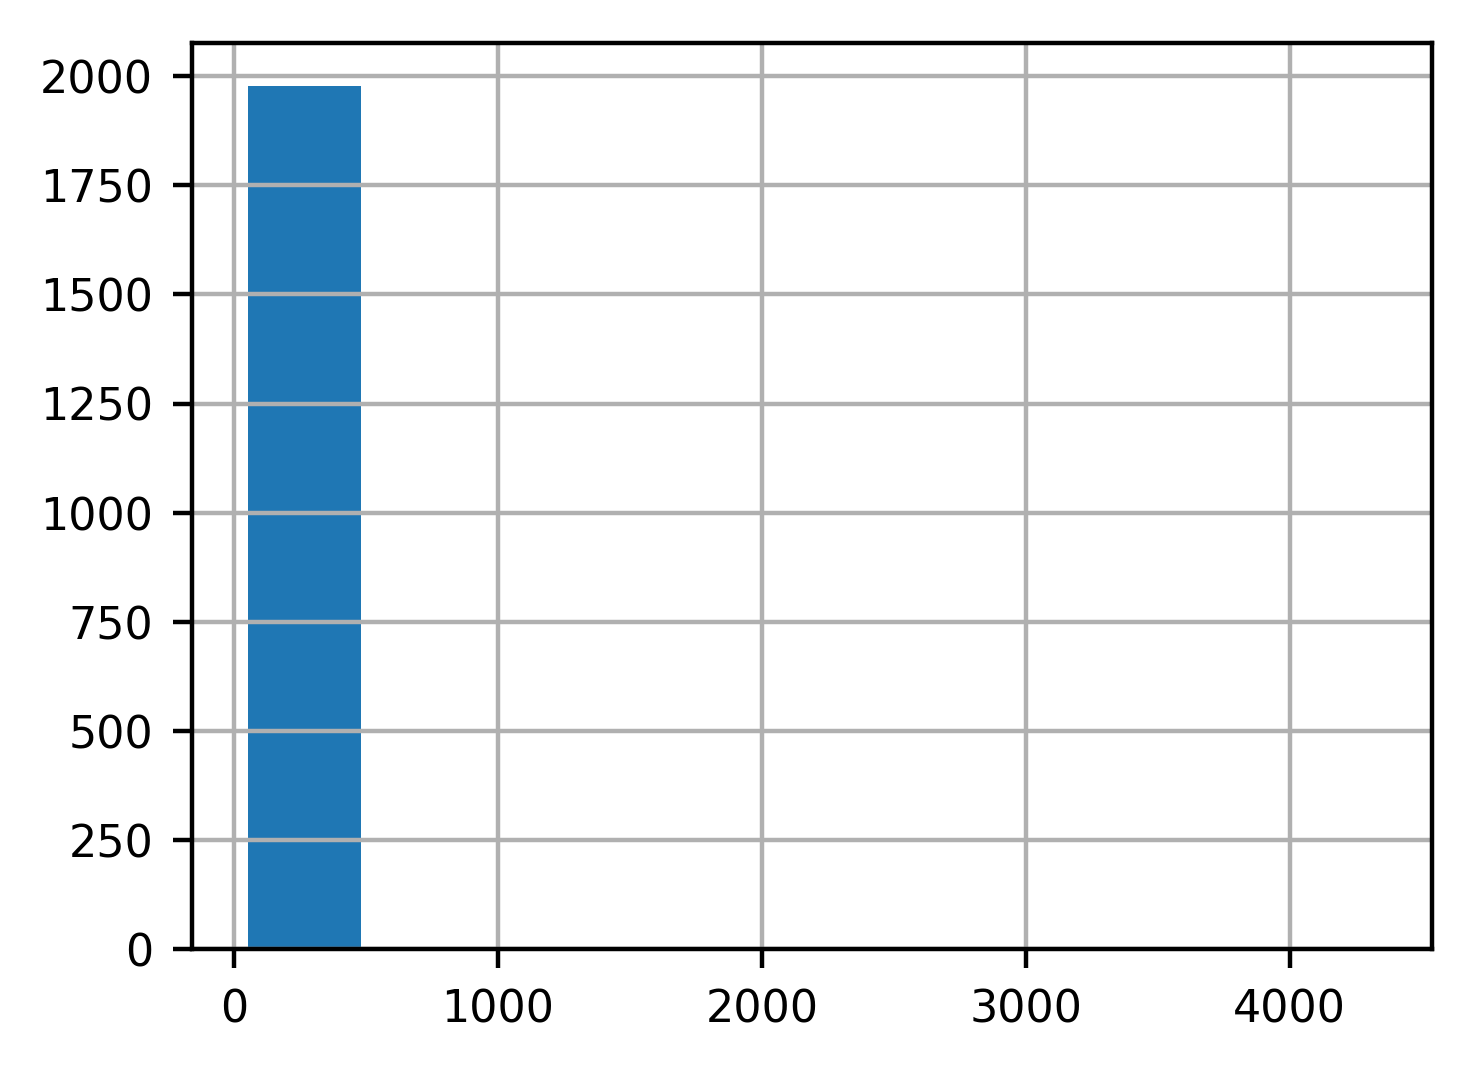

In [43]:
train_avg_MRR["AVG_REMOVAL_RATE"].hist()

Here we find that there are 4 records siginificantly higher than normal values,  
which is considered as outliers and deleted from the data set.

In [11]:
train_df = train_df.loc[train_df["AVG_REMOVAL_RATE"] < 1000, ] 

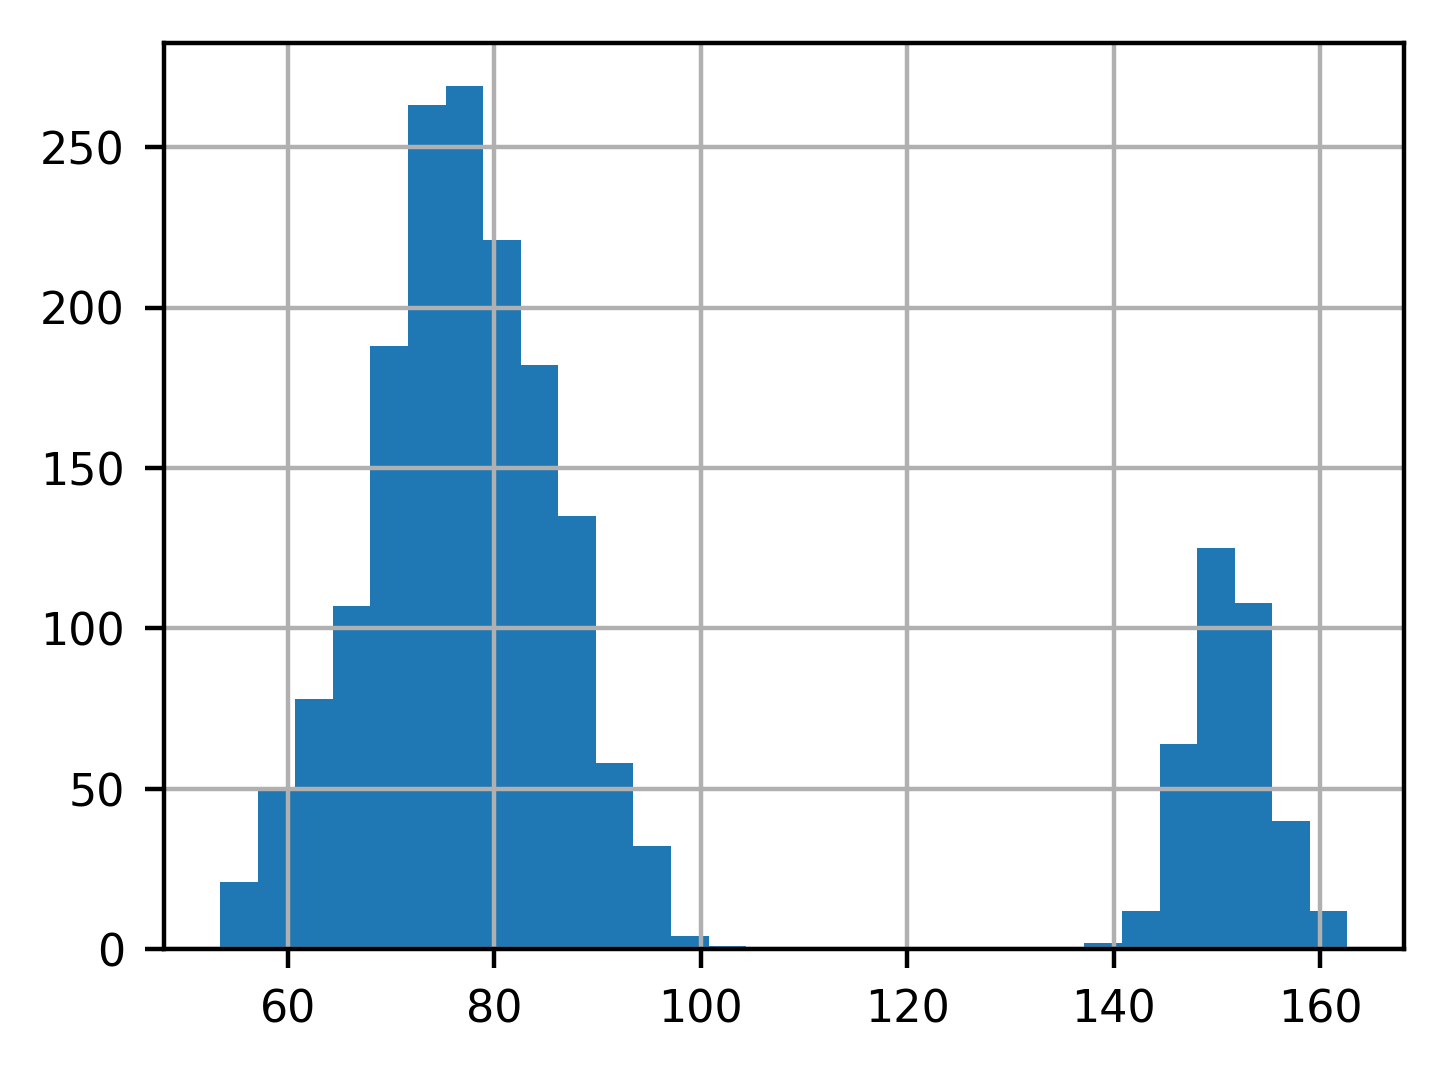

In [44]:
train_df["AVG_REMOVAL_RATE"].hist(bins = 30)

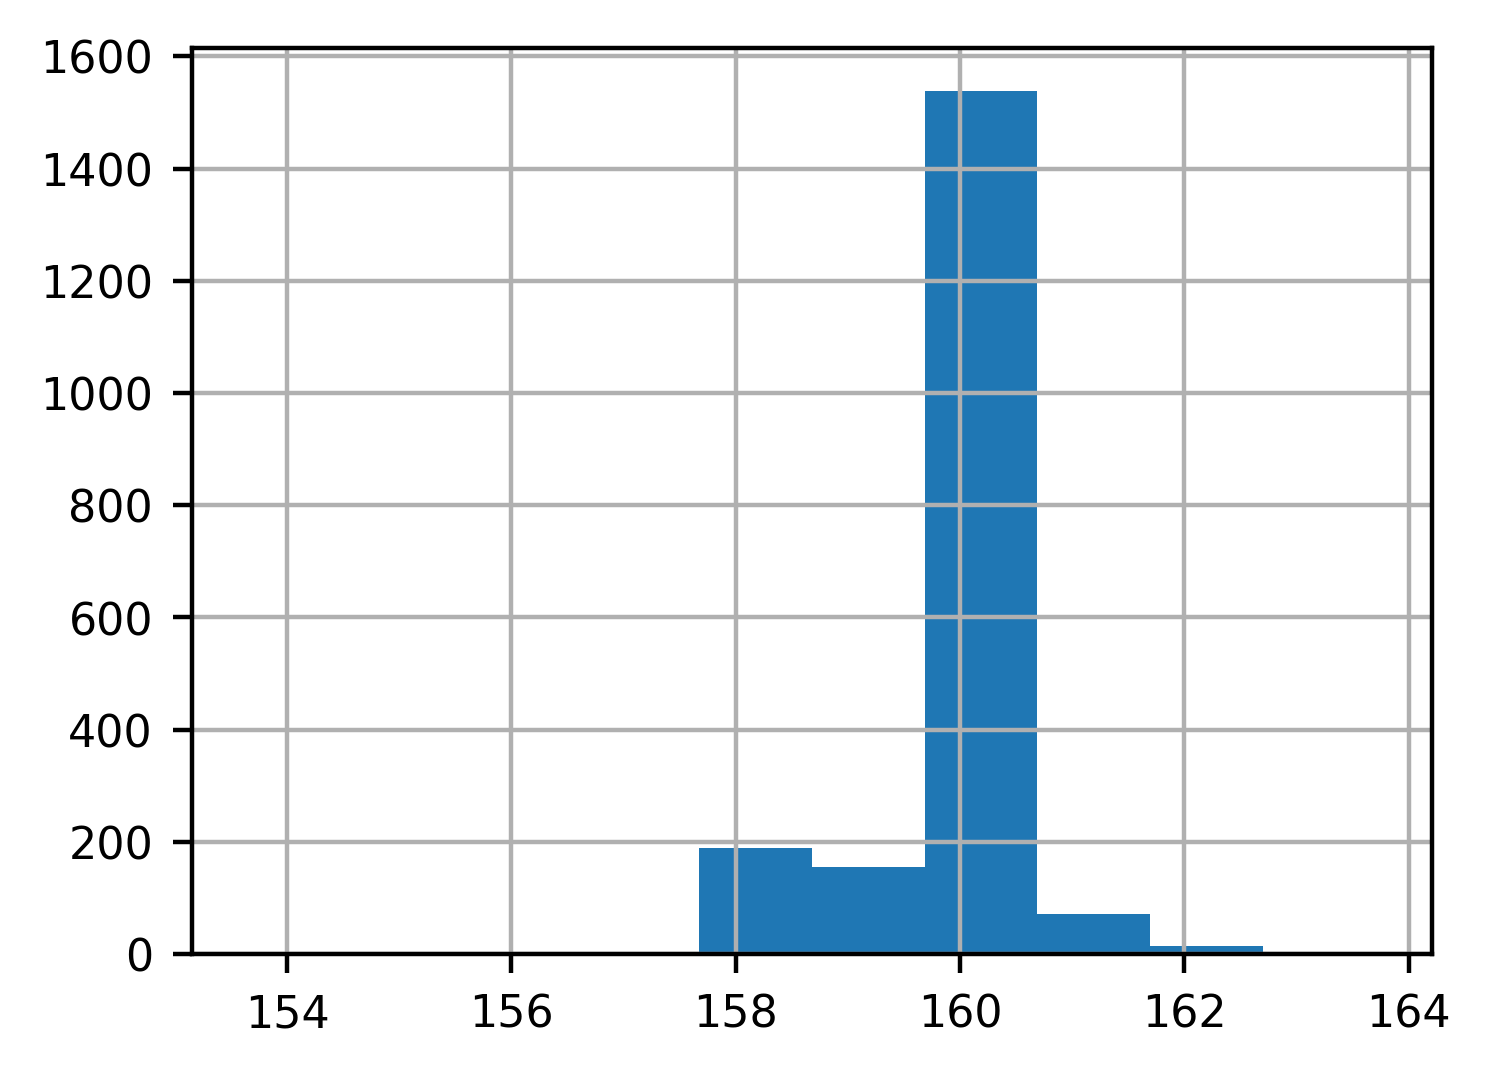

In [45]:
train_df["HEAD_ROTATION"].hist()
train_df = train_df.loc[train_df["HEAD_ROTATION"] > 140, ] 

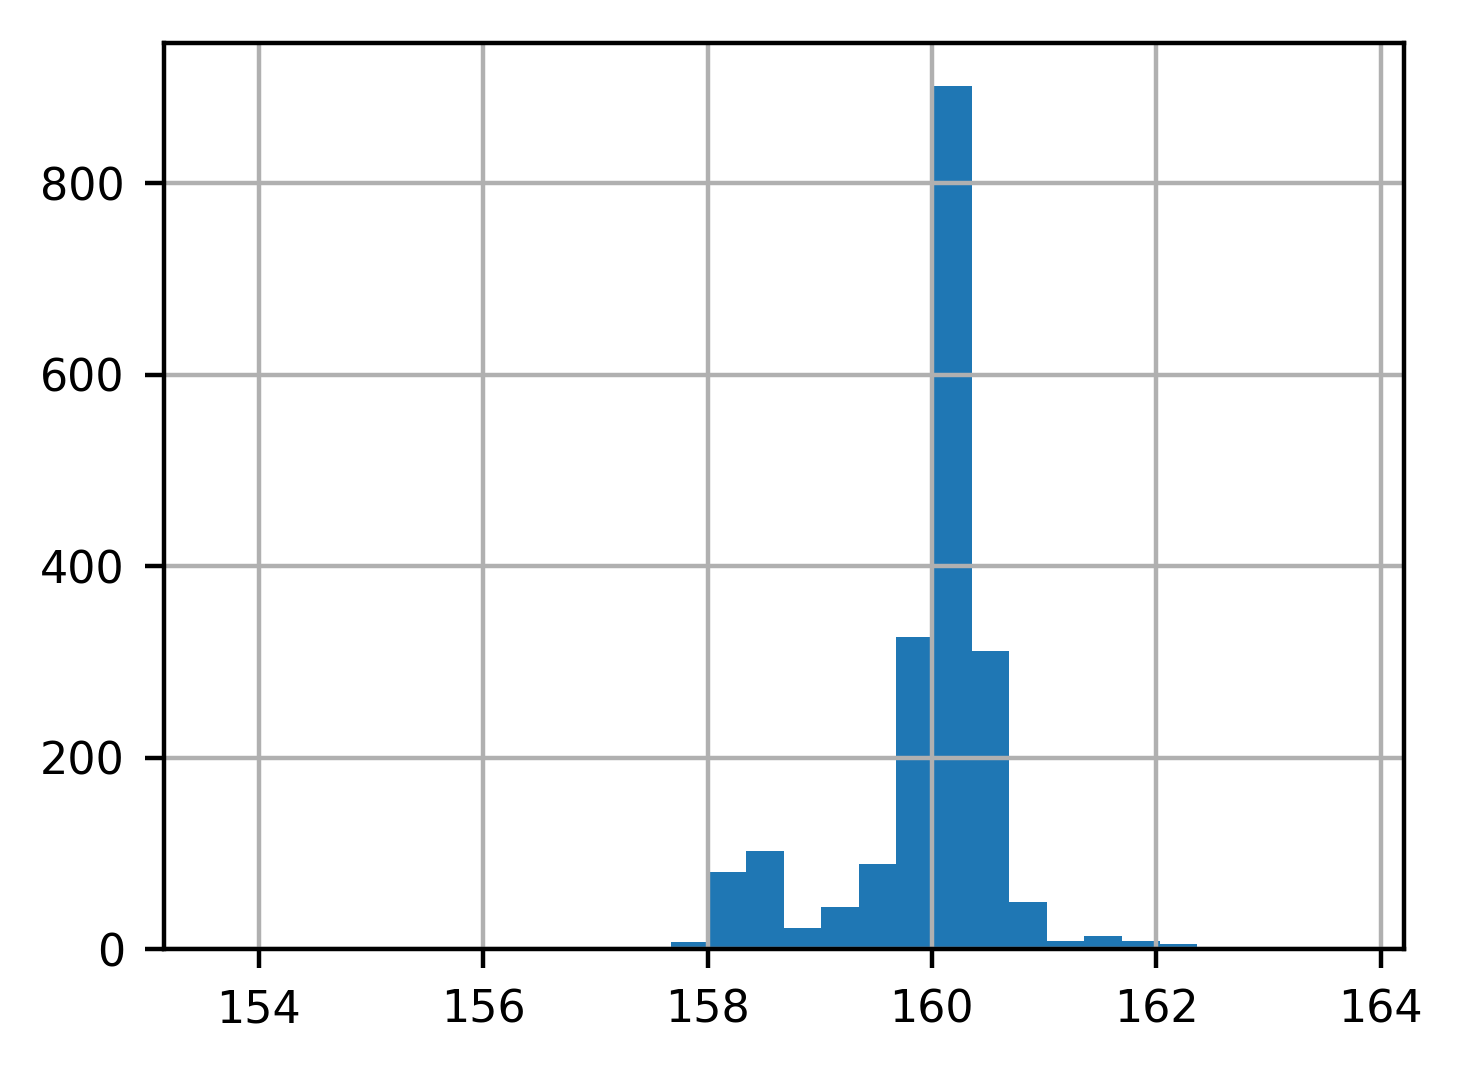

In [46]:
train_df["HEAD_ROTATION"].hist(bins = 30)

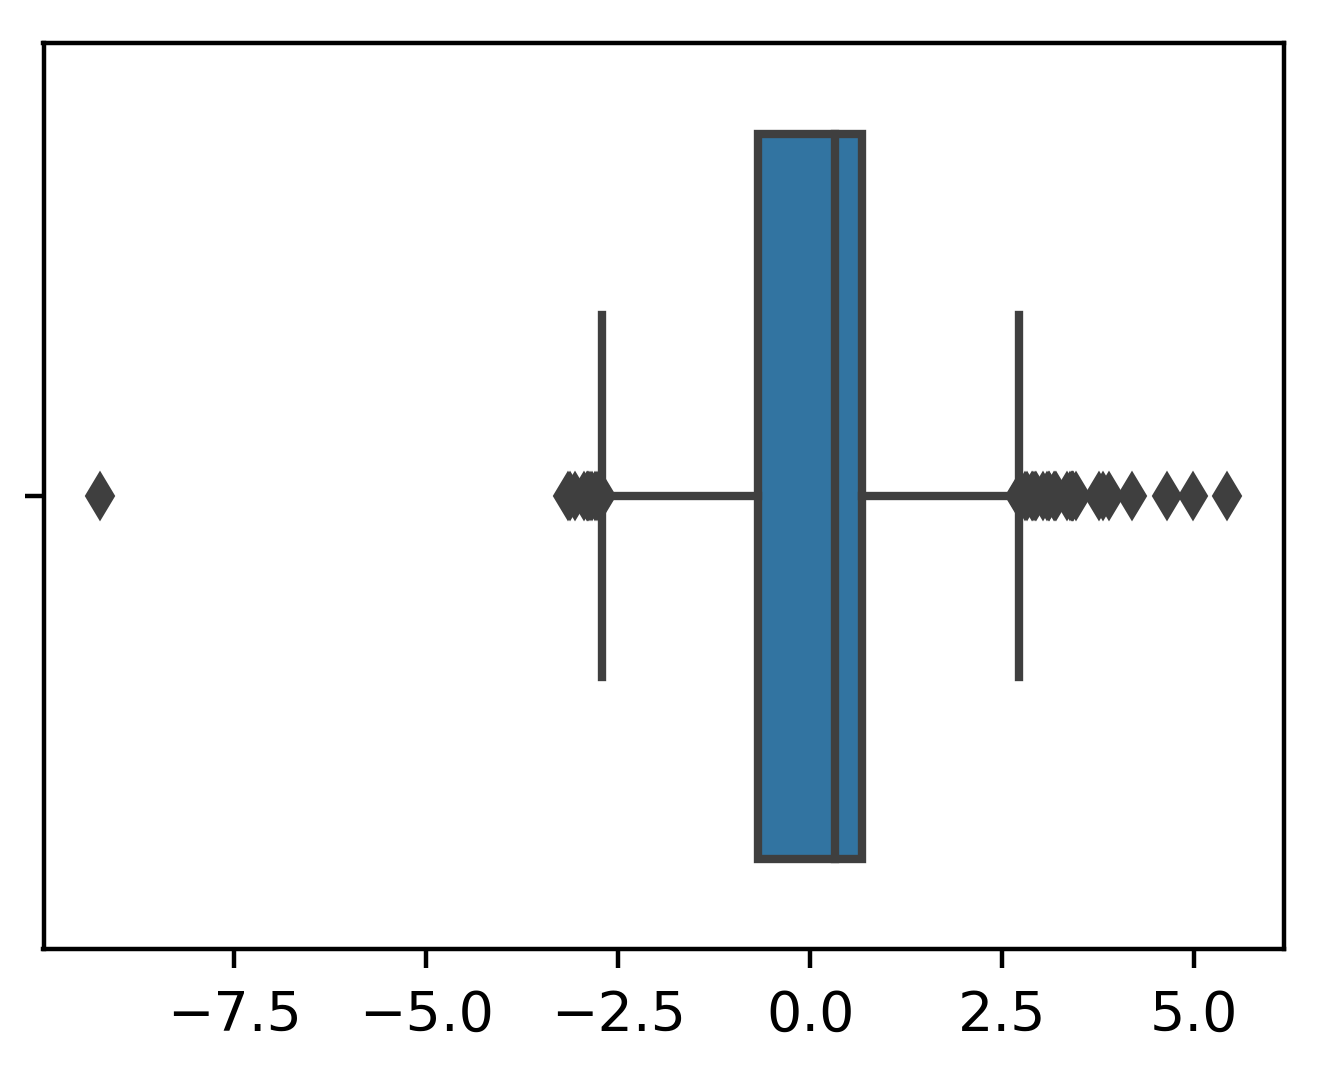

In [15]:
train_stand = (train_df - train_df.mean()) / train_df.std()
# train_stand.plot(kind = 'hist', subplots = True, layout = (5, 5), use_index = False, 
                 # size = (20, 20), fontsize = 8, title = train_df.columns.values, legend = False)
    
sns.boxplot(train_stand)

In [16]:
train_df.describe()

,AVG_REMOVAL_RATE,CHAMBER,USAGE_OF_BACKING_FILM,USAGE_OF_DRESSER,USAGE_OF_POLISHING_TABLE,USAGE_OF_DRESSER_TABLE,PRESSURIZED_CHAMBER_PRESSURE,MAIN_OUTER_AIR_BAG_PRESSURE,CENTER_AIR_BAG_PRESSURE,RETAINER_RING_PRESSURE,...,USAGE_OF_MEMBRANE,USAGE_OF_PRESSURIZED_SHEET,SLURRY_FLOW_LINE_A,SLURRY_FLOW_LINE_B,SLURRY_FLOW_LINE_C,WAFER_ROTATION,STAGE_ROTATION,HEAD_ROTATION,DRESSING_WATER_STATUS,EDGE_AIR_BAG_PRESSURE
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,...,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,90.293890,4.125573,5041.389098,399.204151,171.095509,3501.675106,49.283874,153.094531,39.594115,1203.712317,...,59.779321,1512.416837,4.207448,0.721097,245.996047,12.683149,52.060690,159.986896,0.424966,28.166864
std,30.047687,1.138606,2874.124601,220.263833,95.813315,481.582077,22.895277,72.263523,18.615698,538.829459,...,34.080528,862.237373,1.764883,0.288278,109.343176,4.728651,19.231082,0.684384,0.270276,13.044525
min,53.426550,1.638889,24.732055,5.343196,0.000000,2664.863764,0.000000,0.000000,0.000000,0.000000,...,0.293265,7.419617,0.000000,0.000000,0.000000,0.000000,0.000000,153.654391,0.000000,0.000000
25%,72.370350,4.640240,2637.500000,204.764672,86.648104,3052.592155,33.488287,102.863716,27.009324,840.417824,...,31.274704,791.250000,3.203169,0.504463,172.039156,13.791501,55.782938,159.924148,0.156522,19.364041
50%,79.100550,4.660057,5088.324411,408.885992,170.959845,3544.936399,63.704756,195.508223,49.893846,1485.994779,...,60.335877,1526.498036,4.882614,0.903759,311.527788,14.465183,57.912296,160.146077,0.486243,35.567138
75%,88.593375,4.672414,7457.347995,591.944444,256.560547,3923.003496,65.870648,204.027313,53.413630,1626.714636,...,88.427051,2237.204399,5.512029,0.906463,327.595756,14.796533,59.291418,160.309677,0.582647,38.113229
max,162.641700,5.911508,10532.500000,771.656805,355.312974,4305.365103,127.565756,434.633935,97.625226,2080.854152,...,124.891304,3159.750000,10.235962,1.383069,430.157895,24.826207,132.716577,163.704659,1.000000,62.884805


In [17]:
print("Length of train set: {0}\nLength of test set: {1}\n".
      format(len(train_df), len(test_df)))

Length of train set: 1972
Length of test set: 848



In [18]:
feature_names = train_df.columns[1:]
X_train = train_df.iloc[:, 1: ].as_matrix()
y_train = train_df.iloc[:, 0].as_matrix()
X_test = test_df.iloc[:, 1: ].as_matrix()
y_test = test_df.iloc[:, 0].as_matrix()


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
X_train.shape

(1972, 20)

# 2. Elastic Net

In [20]:
l1_ratio = 0.1 * np.arange(1, 11)
regr = ElasticNetCV(cv=5, l1_ratio = l1_ratio, random_state=0, max_iter = 20000)
regr.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
       max_iter=20000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0)

In [121]:
print("Optimal alpha is {0}".format(regr.l1_ratio_))
print("Optimal lambda is {0}".format(regr.alpha_))

Optimal alpha is 1.0
Optimal lambda is 0.028878914477909846


train root mean square error is: 5.865598847288283


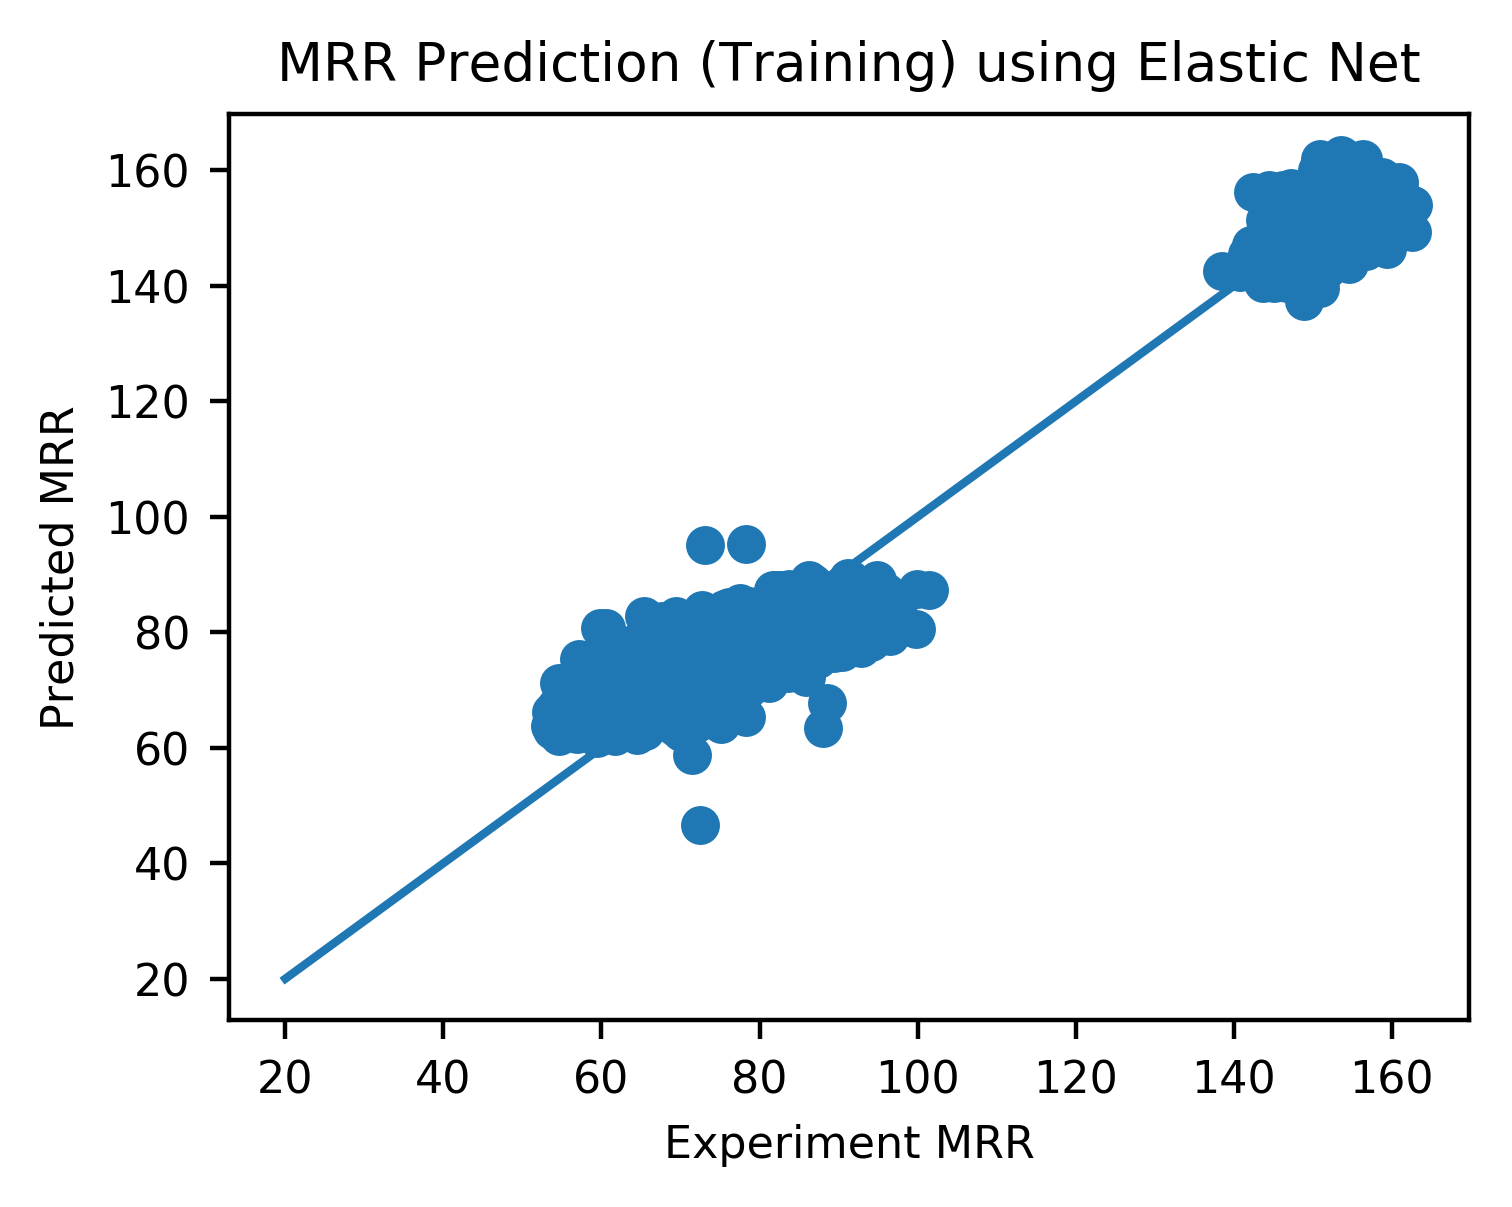

In [47]:
y_train_predict = regr.predict(X_train)
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_predict))
print('train root mean square error is: {0}'.format(rmse_train))
plt.scatter(y_train, y_train_predict)
plt.plot([20, 160], [20, 160])
plt.xlabel("Experiment MRR")
plt.ylabel("Predicted MRR")
plt.title("MRR Prediction (Training) using Elastic Net")
plt.show()

test root mean square error is: 6.214327870537254


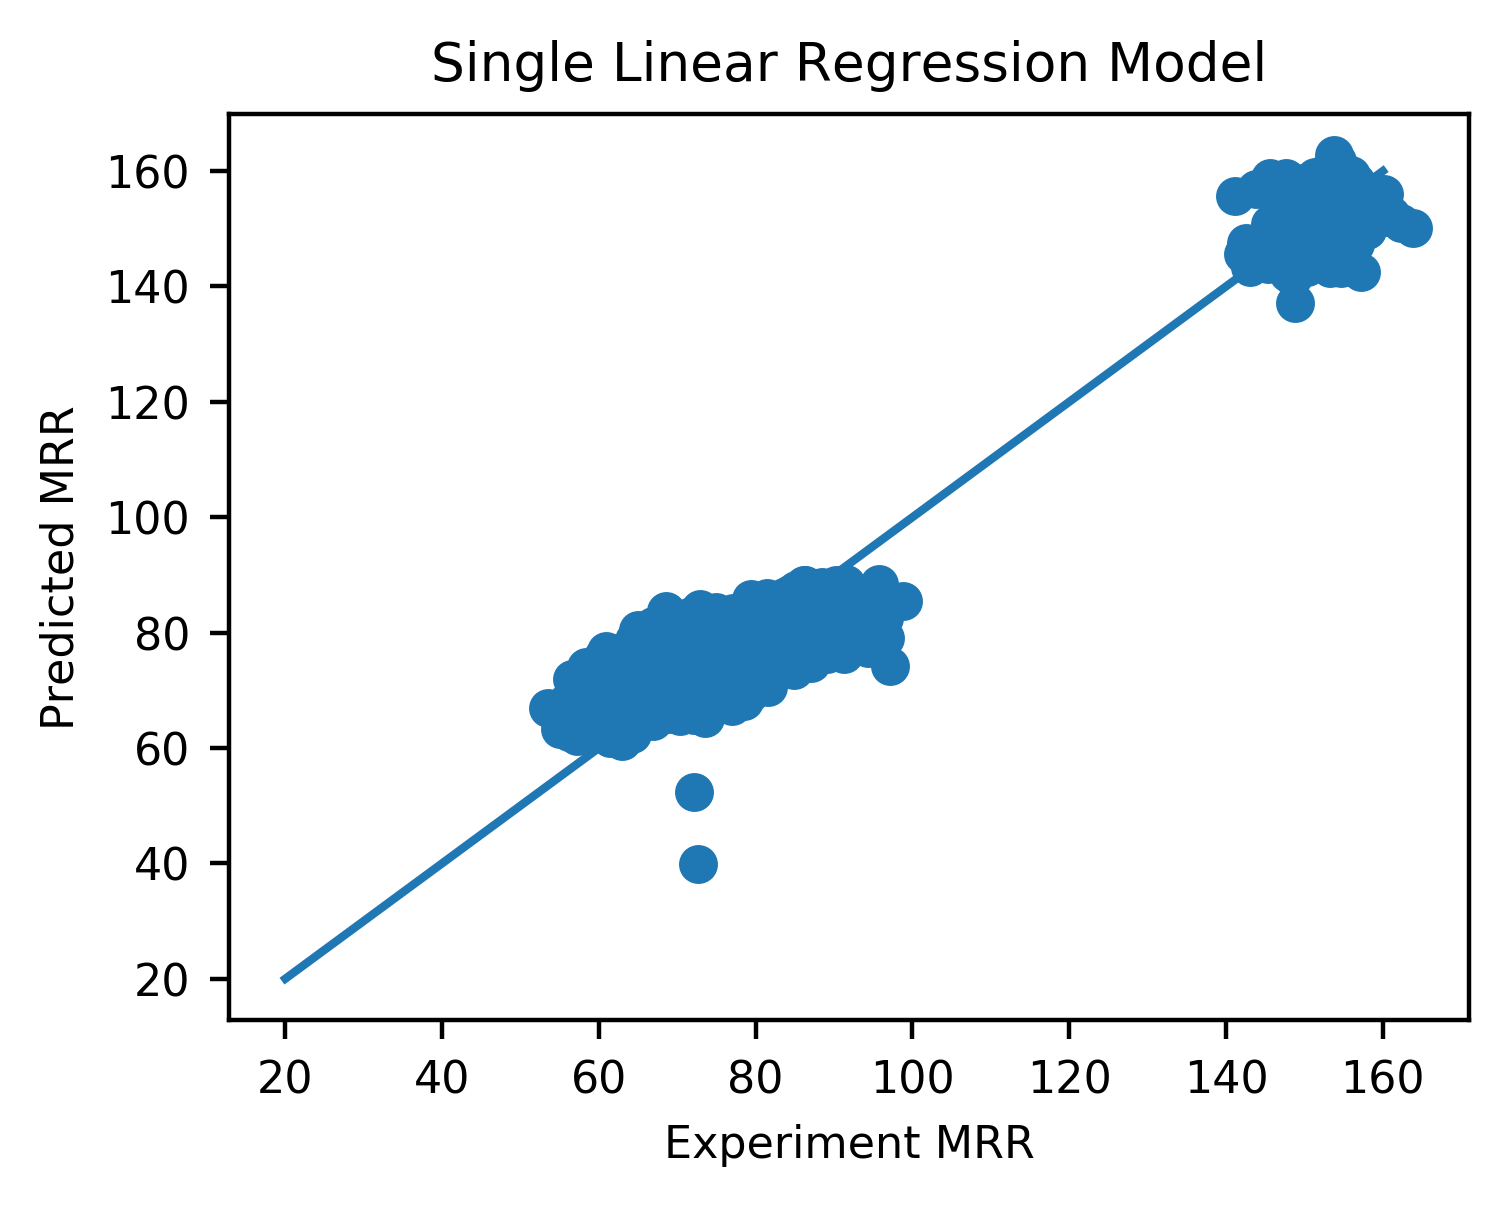

In [123]:
y_test_predict = regr.predict(X_test)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))
print('test root mean square error is: {0}'.format(rmse_test))
plt.scatter(y_test, y_test_predict)
plt.plot([20, 160], [20, 160])
plt.xlabel("Experiment MRR")
plt.ylabel("Predicted MRR")
plt.title("Single Linear Regression Model")
plt.show()

# 3. Gadient Boosting Prediction

In [23]:
dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, feature_names=feature_names)

In [91]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'min_child_weight': 3,
    'gamma': 0.3
}

[0]	train-rmse:89.9946+0.486634	test-rmse:89.9916+0.961407
[100]	train-rmse:4.40964+0.043296	test-rmse:4.95265+0.185275
[200]	train-rmse:3.50123+0.0344953	test-rmse:4.47744+0.12023
[300]	train-rmse:3.01402+0.027417	test-rmse:4.31311+0.130449
[400]	train-rmse:2.66077+0.0219271	test-rmse:4.23763+0.122305
[500]	train-rmse:2.37677+0.0216317	test-rmse:4.18801+0.13072
[600]	train-rmse:2.1498+0.0194282	test-rmse:4.15674+0.137153
[700]	train-rmse:1.95224+0.0157087	test-rmse:4.1415+0.136566
[800]	train-rmse:1.78862+0.0105823	test-rmse:4.12624+0.137899
[900]	train-rmse:1.63882+0.00506905	test-rmse:4.1188+0.141812
[1000]	train-rmse:1.50851+0.00215408	test-rmse:4.10876+0.140049
test-rmse-mean     4.106870
test-rmse-std      0.138837
train-rmse-mean    1.479706
train-rmse-std     0.004323
Name: 1025, dtype: float64


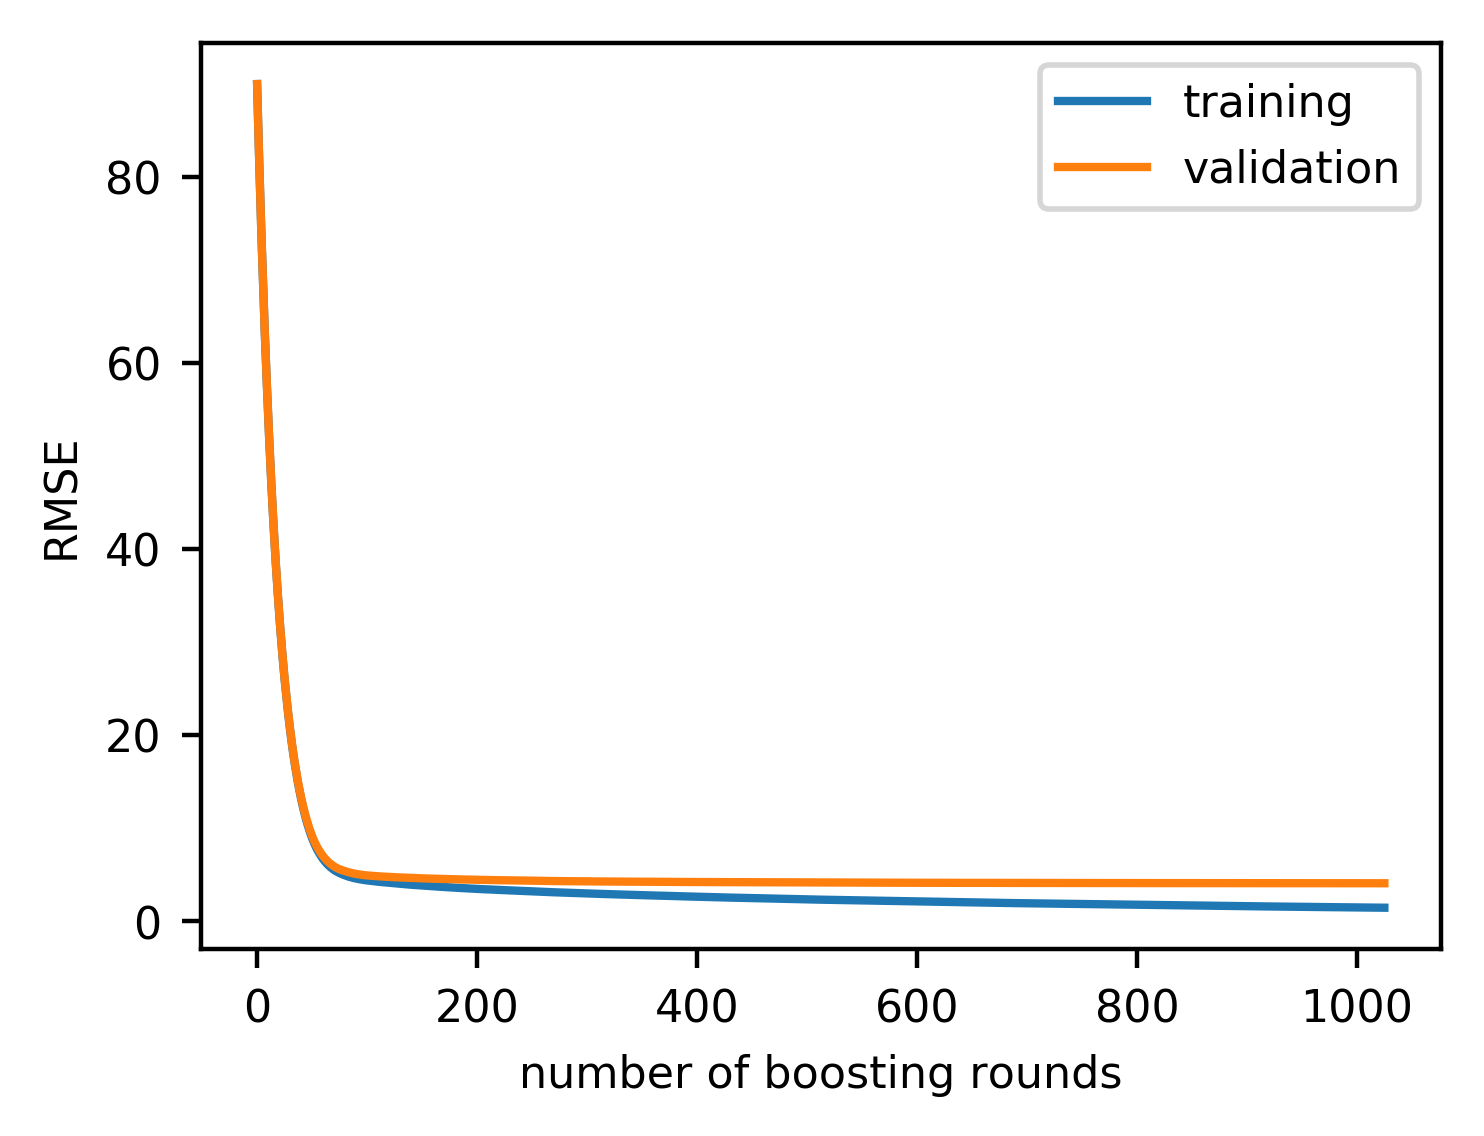

In [92]:
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=2000, early_stopping_rounds=20,
   verbose_eval=100, show_stdv=True)

print(cv_result.iloc[-1])

plt.plot(cv_result['train-rmse-mean'], label = 'training')
plt.plot(cv_result['test-rmse-mean'], label = 'validation' )
plt.legend()
plt.xlabel('number of boosting rounds')
plt.ylabel('RMSE')
num_boost_rounds = len(cv_result)

In [1]:
model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)
y1_train_predict = model.predict(dtrain)
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_predict))
print('train root mean square error is: {0}'.format(rmse_train))
plt.scatter(y1_train, y1_train_predict)
plt.plot([20, 160], [20, 160])
plt.xlabel("Experiment MRR")
plt.ylabel("Predicted MRR")
plt.title("MRR Prdiction (Training) using XGBoost")
plt.show()

NameError: name 'xgb' is not defined

Test root mean square error is: 3.840260570690467


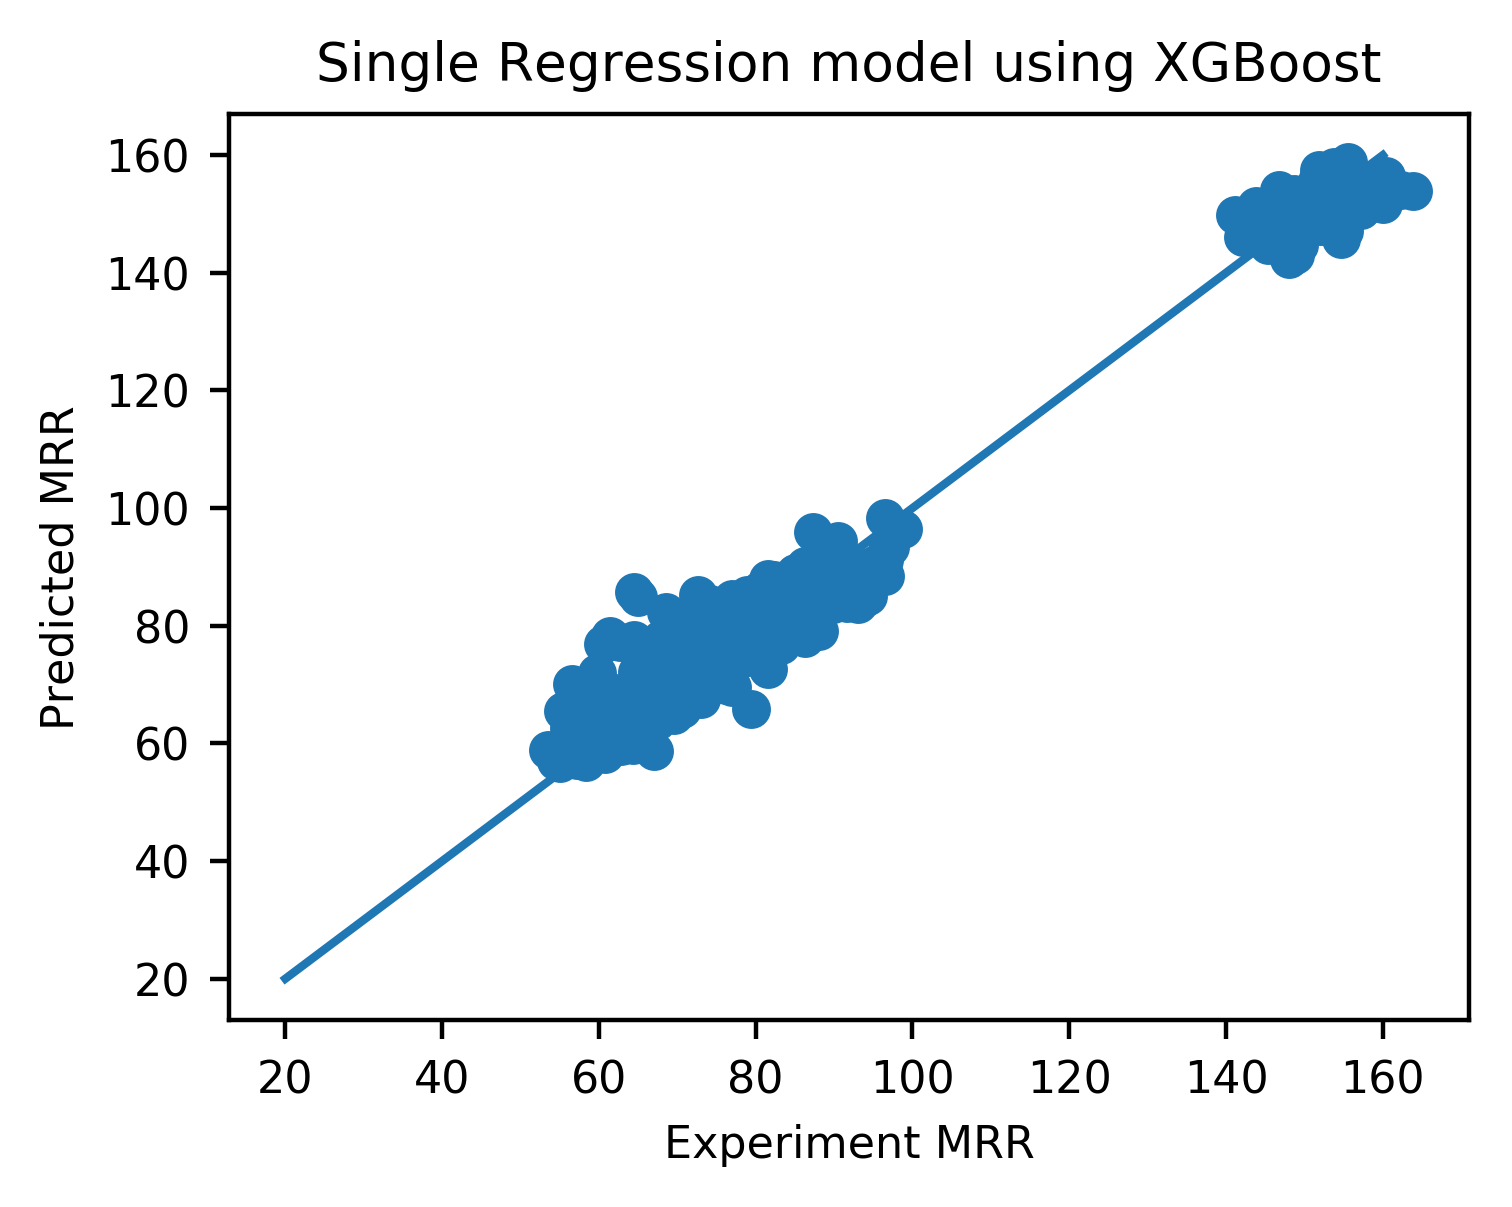

In [95]:
y_test_predict = model.predict(dtest)
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))
print('Test root mean square error is: {0}'.format(rmse_test))
plt.scatter(y_test, y_test_predict)
plt.plot([20, 160], [20, 160])
plt.xlabel("Experiment MRR")
plt.ylabel("Predicted MRR")
plt.title("Single Regression model using XGBoost")
plt.show()

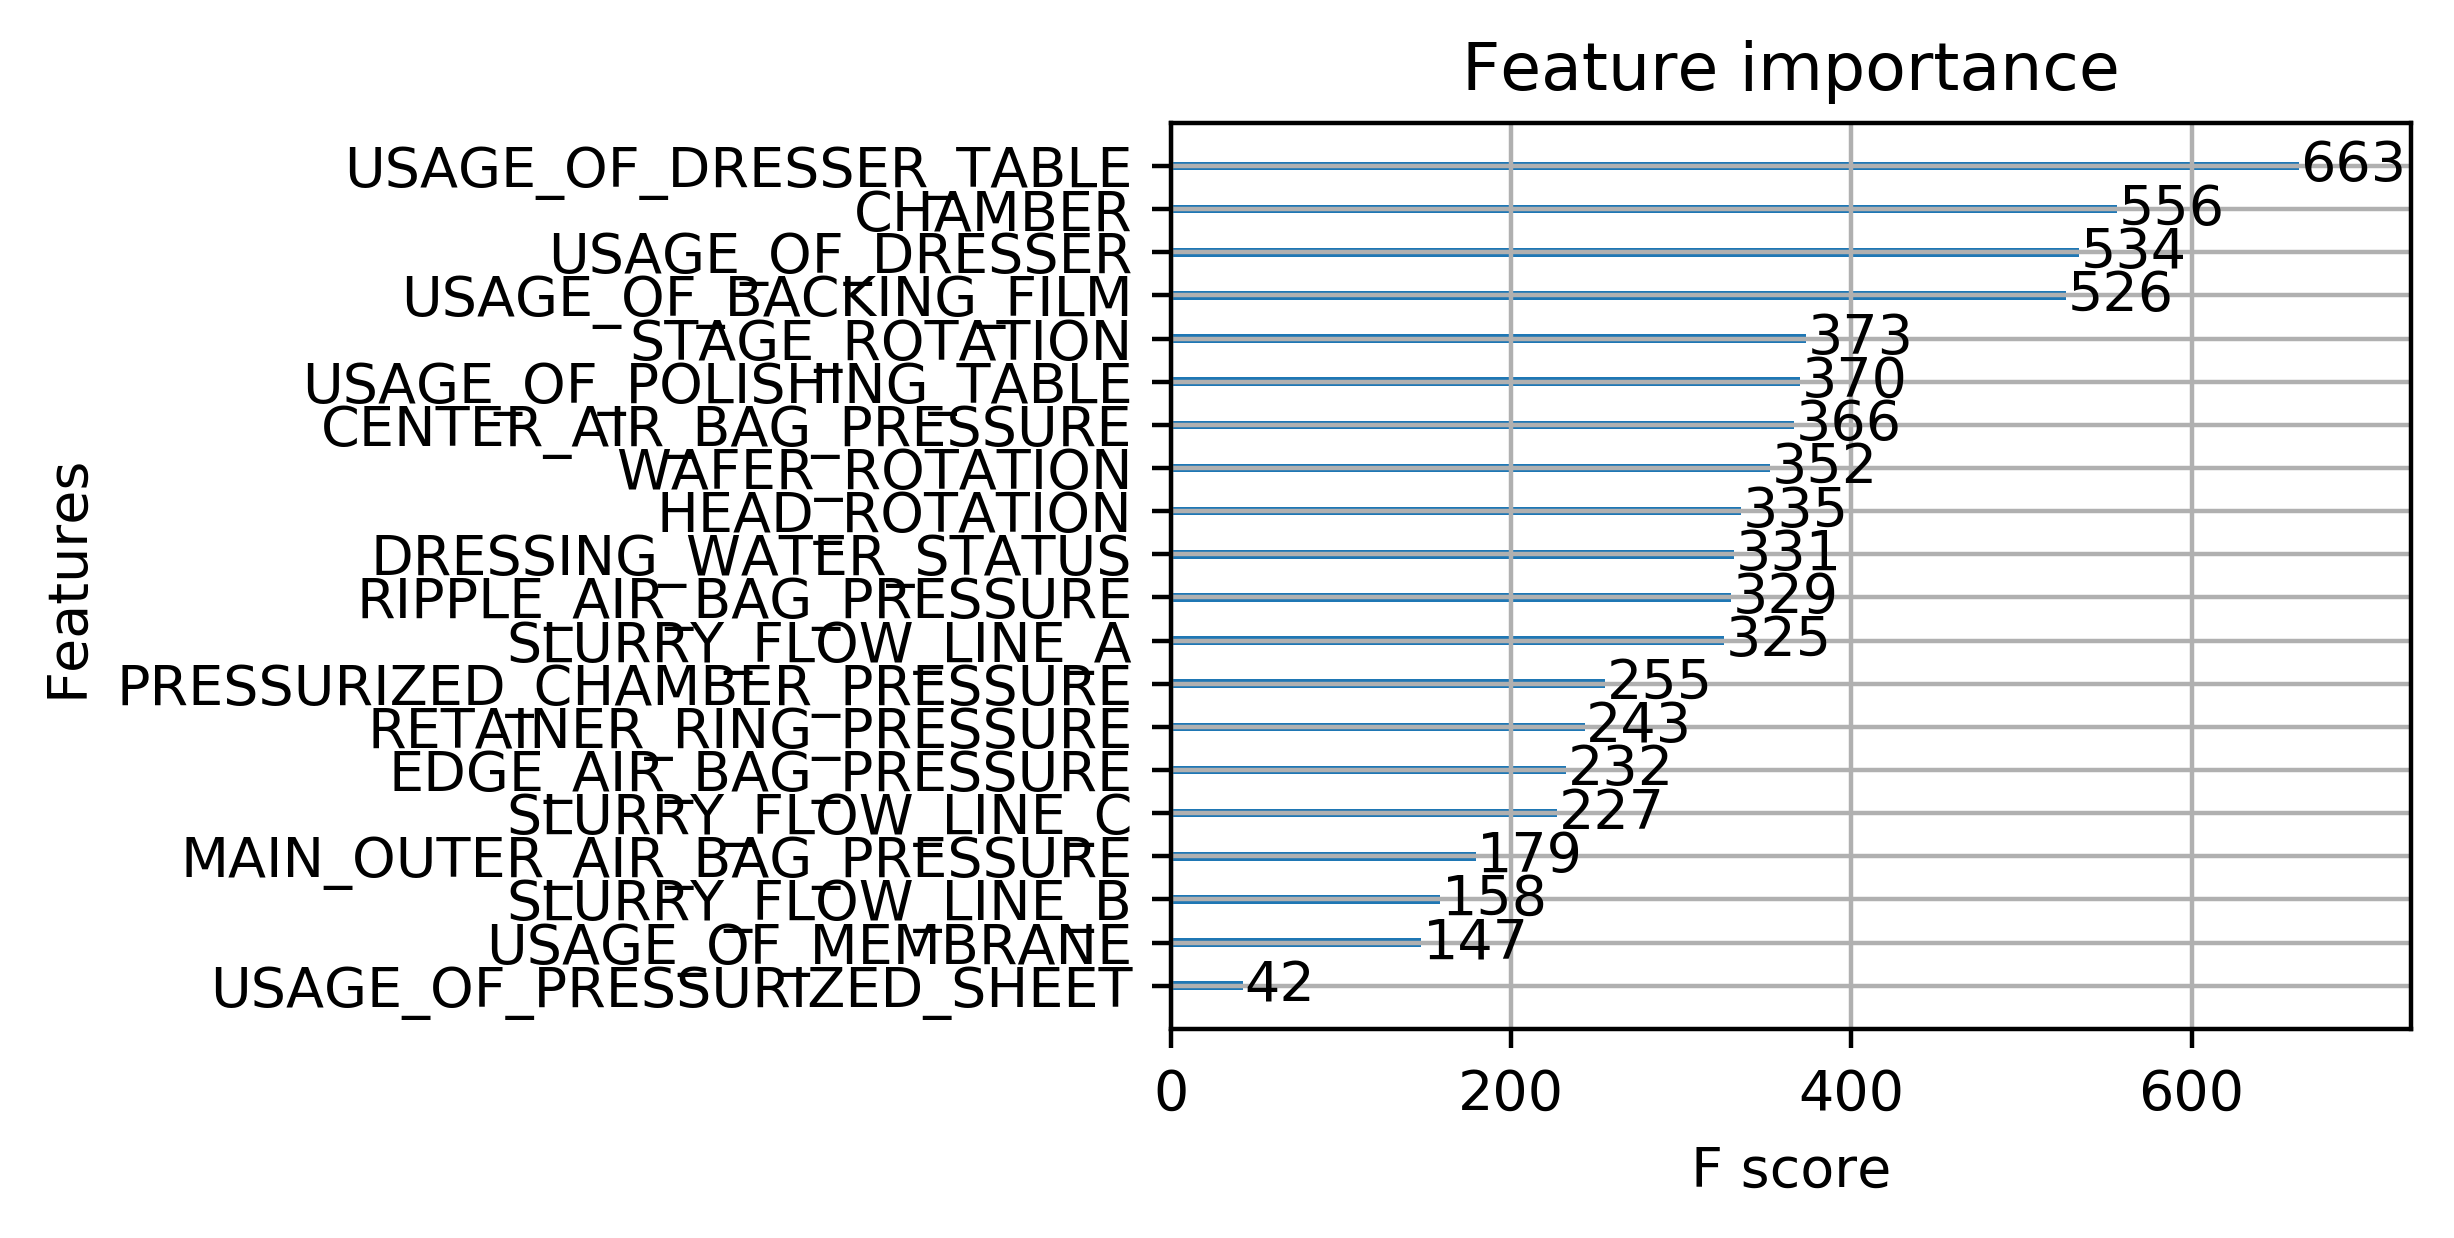

In [29]:
xgb.plot_importance(model)

# 3. Boosting classifier + Boosting regression

In [30]:
# classifier parameter
xgb_class_params = {
    'eta': 0.05,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective':'binary:logistic',
    'eval_metric': 'error',
    'silent': 1,
    'min_child_weight': 3,
    'gamma': 0.3
}

In [31]:
# prepare the data for the classifier
y_train_class = y_train >= 120.0
y_test_class = y_test >= 120.0
dtrain_class = xgb.DMatrix(X_train, y_train_class, feature_names=feature_names)
dtest_class = xgb.DMatrix(X_test, feature_names=feature_names)

# train the classifier
cv_result_class = xgb.cv(xgb_class_params, dtrain_class, num_boost_round=1000, early_stopping_rounds=20,
   verbose_eval=20, show_stdv=True)

[0]	train-error:0+0	test-error:0+0


In [32]:
num_boost_rounds_class = len(cv_result_class)
model_class = xgb.train(xgb_class_params, dtrain_class, num_boost_round=num_boost_rounds_class)

# evaluate the classifier
y_train_predict_class = model_class.predict(dtrain_class)
y_train_predict_class[y_train_predict_class > 0.5] = True
y_train_predict_class[y_train_predict_class < 0.5] = False
y_train_predict_class = y_train_predict_class.astype('bool')
misclass_rate = 1 - np.sum(y_train_class == y_train_predict_class)/len(y_train_class)
print("Misclassification rate for training set is {}".format(misclass_rate))




y_test_predict_class = model_class.predict(dtest_class)
y_test_predict_class[y_test_predict_class > 0.5] = True
y_test_predict_class[y_test_predict_class < 0.5] = False
y_test_predict_class = y_test_predict_class.astype('bool')
misclass_rate = 1 - np.sum(y_test_class == y_test_predict_class)/len(y_test_class)
print("Misclassification rate for test set is {}".format(misclass_rate))

Misclassification rate for training set is 0.0
Misclassification rate for test set is 0.0


In [33]:
# prepare the seperate training dataset
dtrain_class1 = xgb.DMatrix(X_train[y_train_class], y_train[y_train_class], feature_names=feature_names)

dtrain_class2 = xgb.DMatrix(X_train[np.logical_not(y_train_class)], 
                            y_train[np.logical_not(y_train_class)], 
                            feature_names=feature_names)



[0]	train-rmse:143.296+0.0302716	test-rmse:143.296+0.0434948
[100]	train-rmse:2.28805+0.0629613	test-rmse:2.84855+0.0883968
[200]	train-rmse:1.36544+0.079023	test-rmse:2.60924+0.105699
test-rmse-mean     2.590970
test-rmse-std      0.094551
train-rmse-mean    1.277902
train-rmse-std     0.072608
Name: 220, dtype: float64


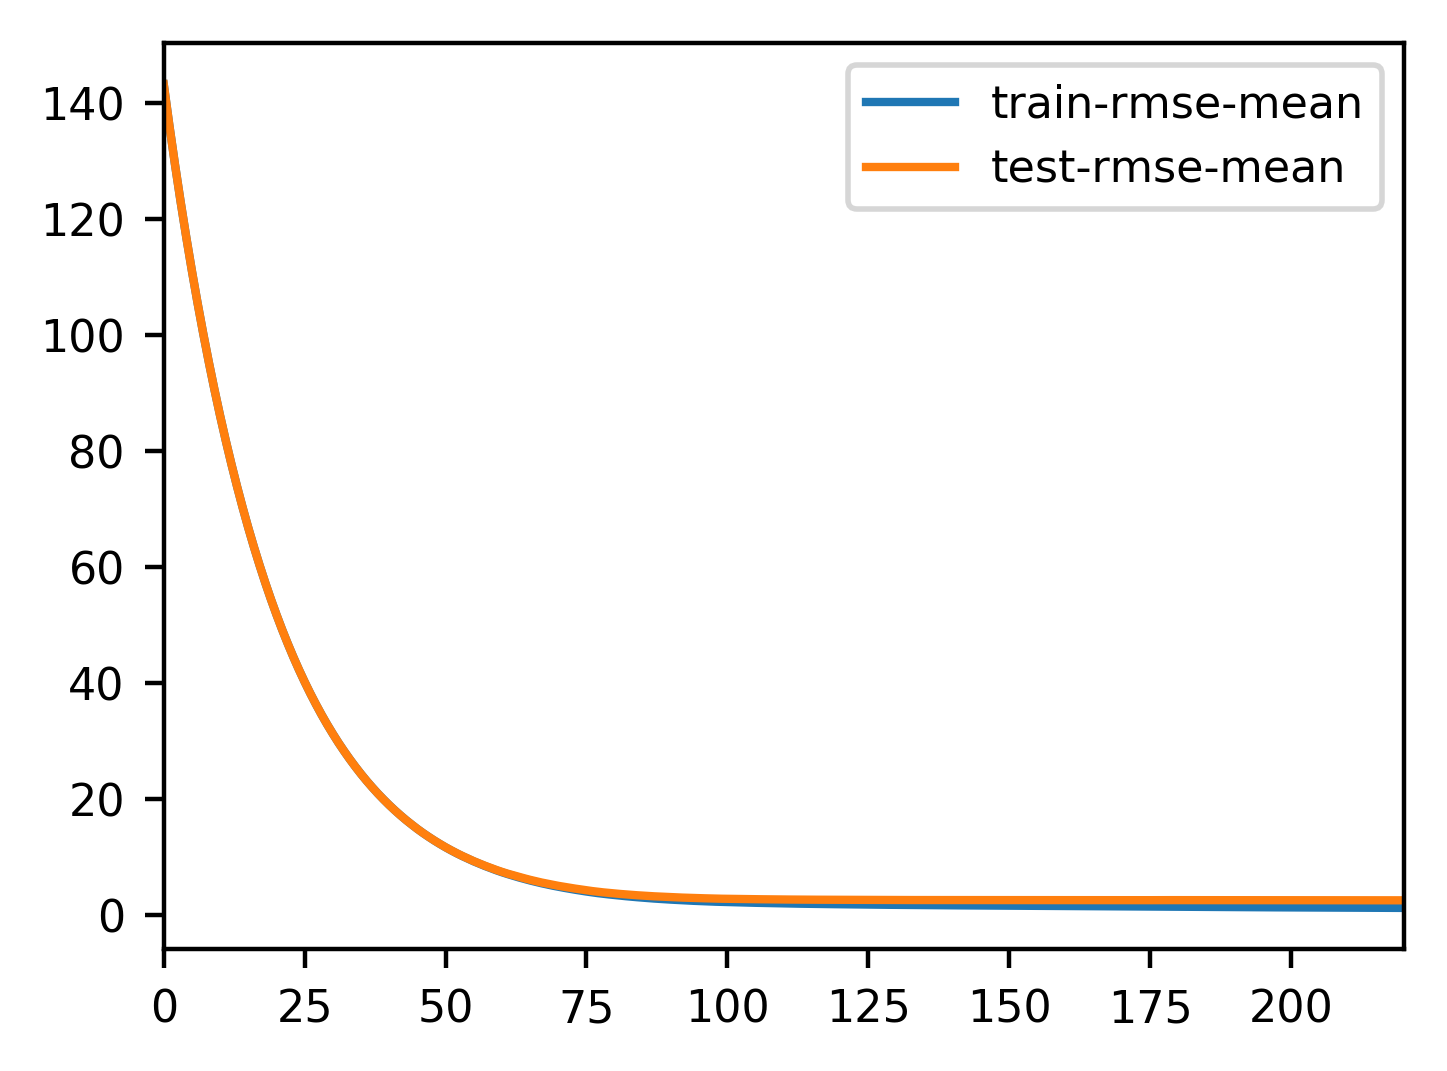

In [107]:
xgb_params_class1 = {
    'eta': 0.05,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'min_child_weight': 3,
    'gamma': 0.3
}

cv_result_class1 = xgb.cv(xgb_params_class1, dtrain_class1, num_boost_round=1000, early_stopping_rounds=20,
   verbose_eval=100, show_stdv=True)
print(cv_result_class1.iloc[-1])
cv_result_class1[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds_class1 = len(cv_result_class1)
model_class1 = xgb.train(xgb_params_class1, dtrain_class1, num_boost_round=num_boost_rounds_class1)

[0]	train-rmse:72.7652+0.0580299	test-rmse:72.7728+0.12981
[100]	train-rmse:2.61313+0.107527	test-rmse:4.33304+0.0492674
[200]	train-rmse:1.40952+0.0848527	test-rmse:4.11173+0.0371218
[300]	train-rmse:0.809329+0.0670131	test-rmse:4.07256+0.0438065
[400]	train-rmse:0.484984+0.0417565	test-rmse:4.05594+0.0405844
test-rmse-mean     4.051279
test-rmse-std      0.039840
train-rmse-mean    0.366074
train-rmse-std     0.030362
Name: 458, dtype: float64


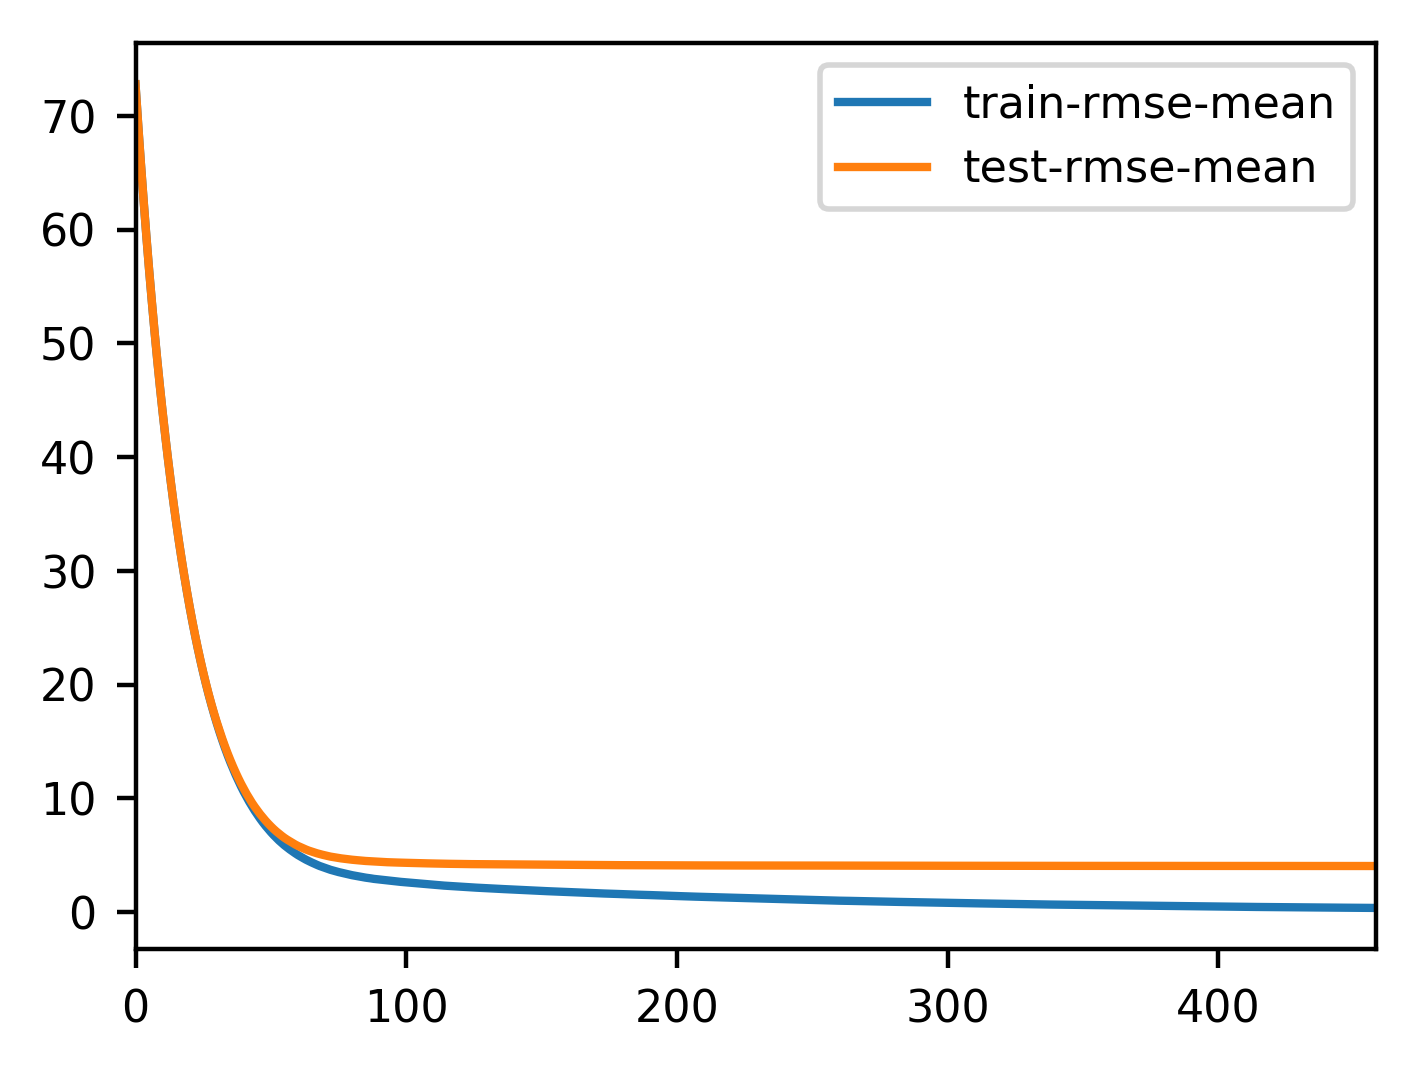

In [117]:
xgb_params_class2 = {
    'eta': 0.05,
    'max_depth':6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'min_child_weight': 3,
    'gamma': 0.3
}

cv_result_class2 = xgb.cv(xgb_params_class2, dtrain_class2, num_boost_round=2000, early_stopping_rounds=20,
   verbose_eval=100, show_stdv=True)
print(cv_result_class2.iloc[-1])
cv_result_class2[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds_class2 = len(cv_result_class2)
model_class2 = xgb.train(xgb_params_class2, dtrain_class2, num_boost_round=num_boost_rounds_class2)

train root mean square error is: 3.0358676000739737


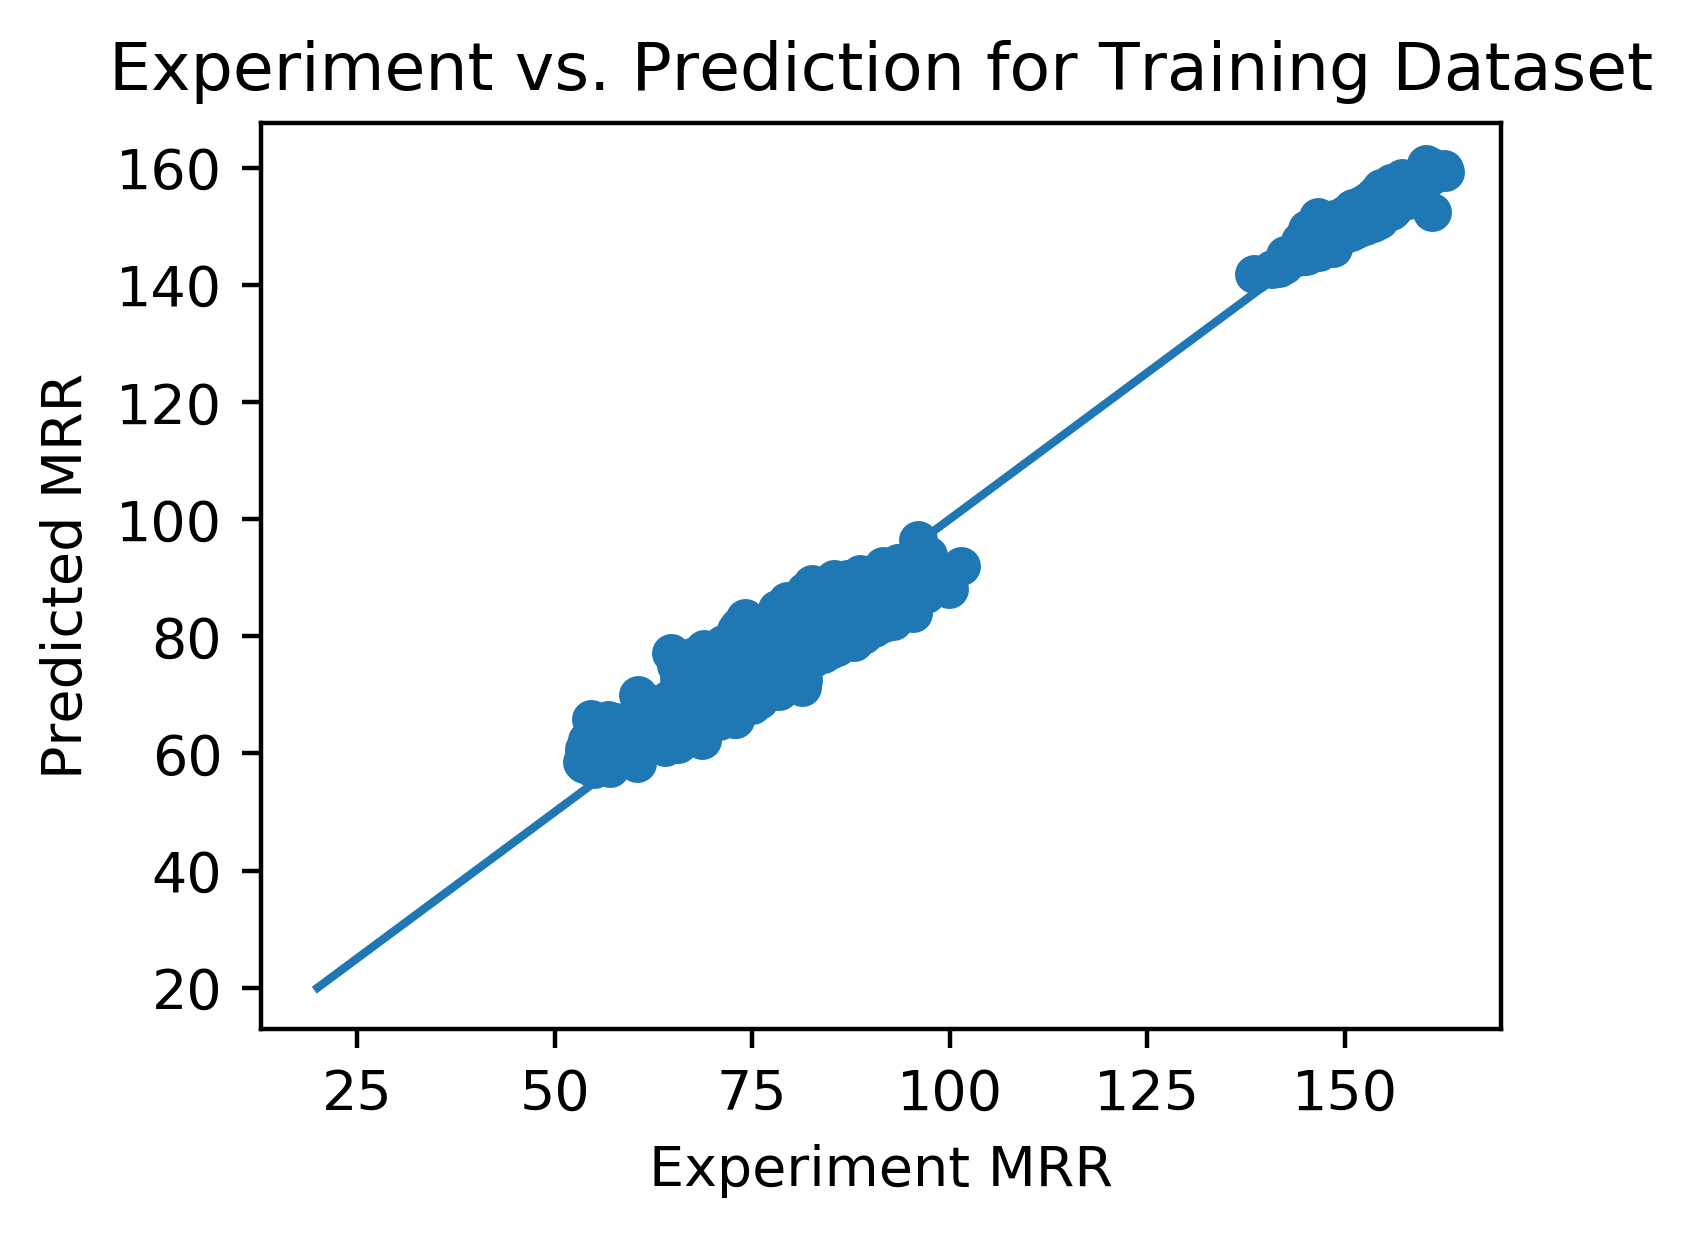

In [36]:
# evlaute the two step model for train data set
# prepare the seperate train dataset
# first predict the class
y_train_predict_class = model_class.predict(dtrain_class)
y_train_predict_class[y_train_predict_class > 0.5] = True
y_train_predict_class[y_train_predict_class < 0.5] = False
y_train_predict_class = y_train_predict_class.astype('bool')

dtrain_class1 = xgb.DMatrix(X_train[y_train_predict_class], 
                            y_train[y_train_predict_class], 
                            feature_names=feature_names)

dtrain_class2 = xgb.DMatrix(X_train[np.logical_not(y_train_predict_class)], 
                            y_train[np.logical_not(y_train_predict_class)], 
                            feature_names=feature_names)



y_train_predict_class1 = model_class1.predict(dtrain_class1)
y_train_predict_class2 = model_class2.predict(dtrain_class2)
y_train_predict[y_train_predict_class] = y_train_predict_class1
y_train_predict[np.logical_not(y_train_predict_class)] = y_train_predict_class2


rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_predict))
print('train root mean square error is: {0}'.format(rmse_train))
plt.scatter(y_train, y_train_predict)
plt.plot([20, 160], [20, 160])
plt.xlabel("Experiment MRR")
plt.ylabel("Predicted MRR")
plt.title("Experi")
plt.show()

test root mean square error is: 3.570022944663937


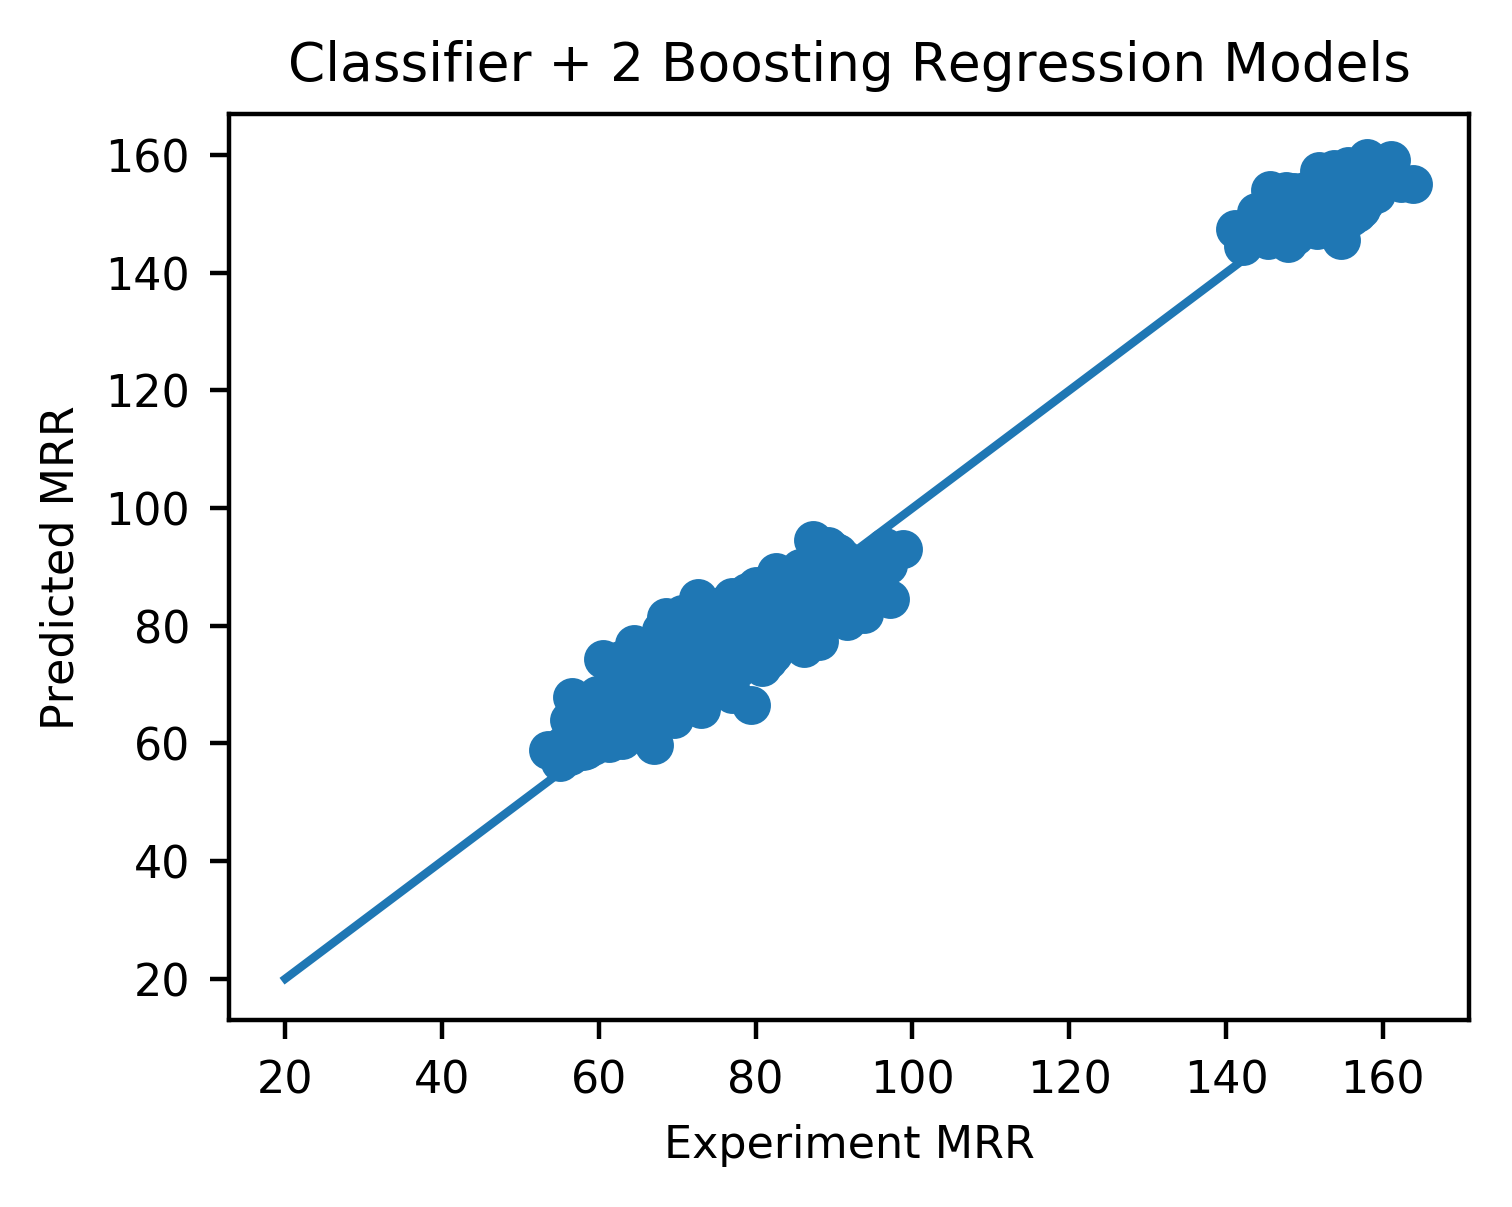

In [118]:
# evlaute the two step model for test data set
# prepare the seperate test dataset
# first predict the class
y_test_predict_class = model_class.predict(dtest_class)
y_test_predict_class[y_test_predict_class > 0.5] = True
y_test_predict_class[y_test_predict_class < 0.5] = False
y_test_predict_class = y_test_predict_class.astype('bool')

dtest_class1 = xgb.DMatrix(X_test[y_test_predict_class], 
                            y_test[y_test_predict_class], 
                            feature_names=feature_names)

dtest_class2 = xgb.DMatrix(X_test[np.logical_not(y_test_predict_class)], 
                            y_test[np.logical_not(y_test_predict_class)], 
                            feature_names=feature_names)



y_test_predict_class1 = model_class1.predict(dtest_class1)
y_test_predict_class2 = model_class2.predict(dtest_class2)
y_test_predict[y_test_predict_class] = y_test_predict_class1
y_test_predict[np.logical_not(y_test_predict_class)] = y_test_predict_class2


rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))
print('test root mean square error is: {0}'.format(rmse_test))
plt.scatter(y_test, y_test_predict)
plt.plot([20, 160], [20, 160])
plt.xlabel("Experiment MRR")
plt.ylabel("Predicted MRR")
plt.title("Classifier + 2 Boosting Regression Models")
plt.show()

# 4. Classifier + ElasticNet

In [38]:
l1_ratio = 0.1 * np.arange(1, 11)
regr_class1 = ElasticNetCV(cv=5, l1_ratio = l1_ratio, random_state=0, max_iter = 20000)
regr_class2 = ElasticNetCV(cv=5, l1_ratio = l1_ratio, random_state=0, max_iter = 20000)
regr_class1.fit(X_train[y_train_class], y_train[y_train_class])
regr_class2.fit(X_train[np.logical_not(y_train_class)], y_train[np.logical_not(y_train_class)])

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
       max_iter=20000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0)

In [122]:
print("Optimal alpha for class 1 is {0}".format(regr_class1.l1_ratio_))
print("Optimal lambda for class 1 is {0}".format(regr_class1.alpha_))
print("Optimal alpha for class 2 is {0}".format(regr_class2.l1_ratio_))
print("Optimal lambda for class 2 is {0}".format(regr_class2.alpha_))

Optimal alpha for class 1 is 0.1
Optimal lambda for class 1 is 0.31214237367213843
Optimal alpha for class 2 is 1.0
Optimal lambda for class 2 is 0.004642634414883126


train root mean square error is: 5.208451998565797


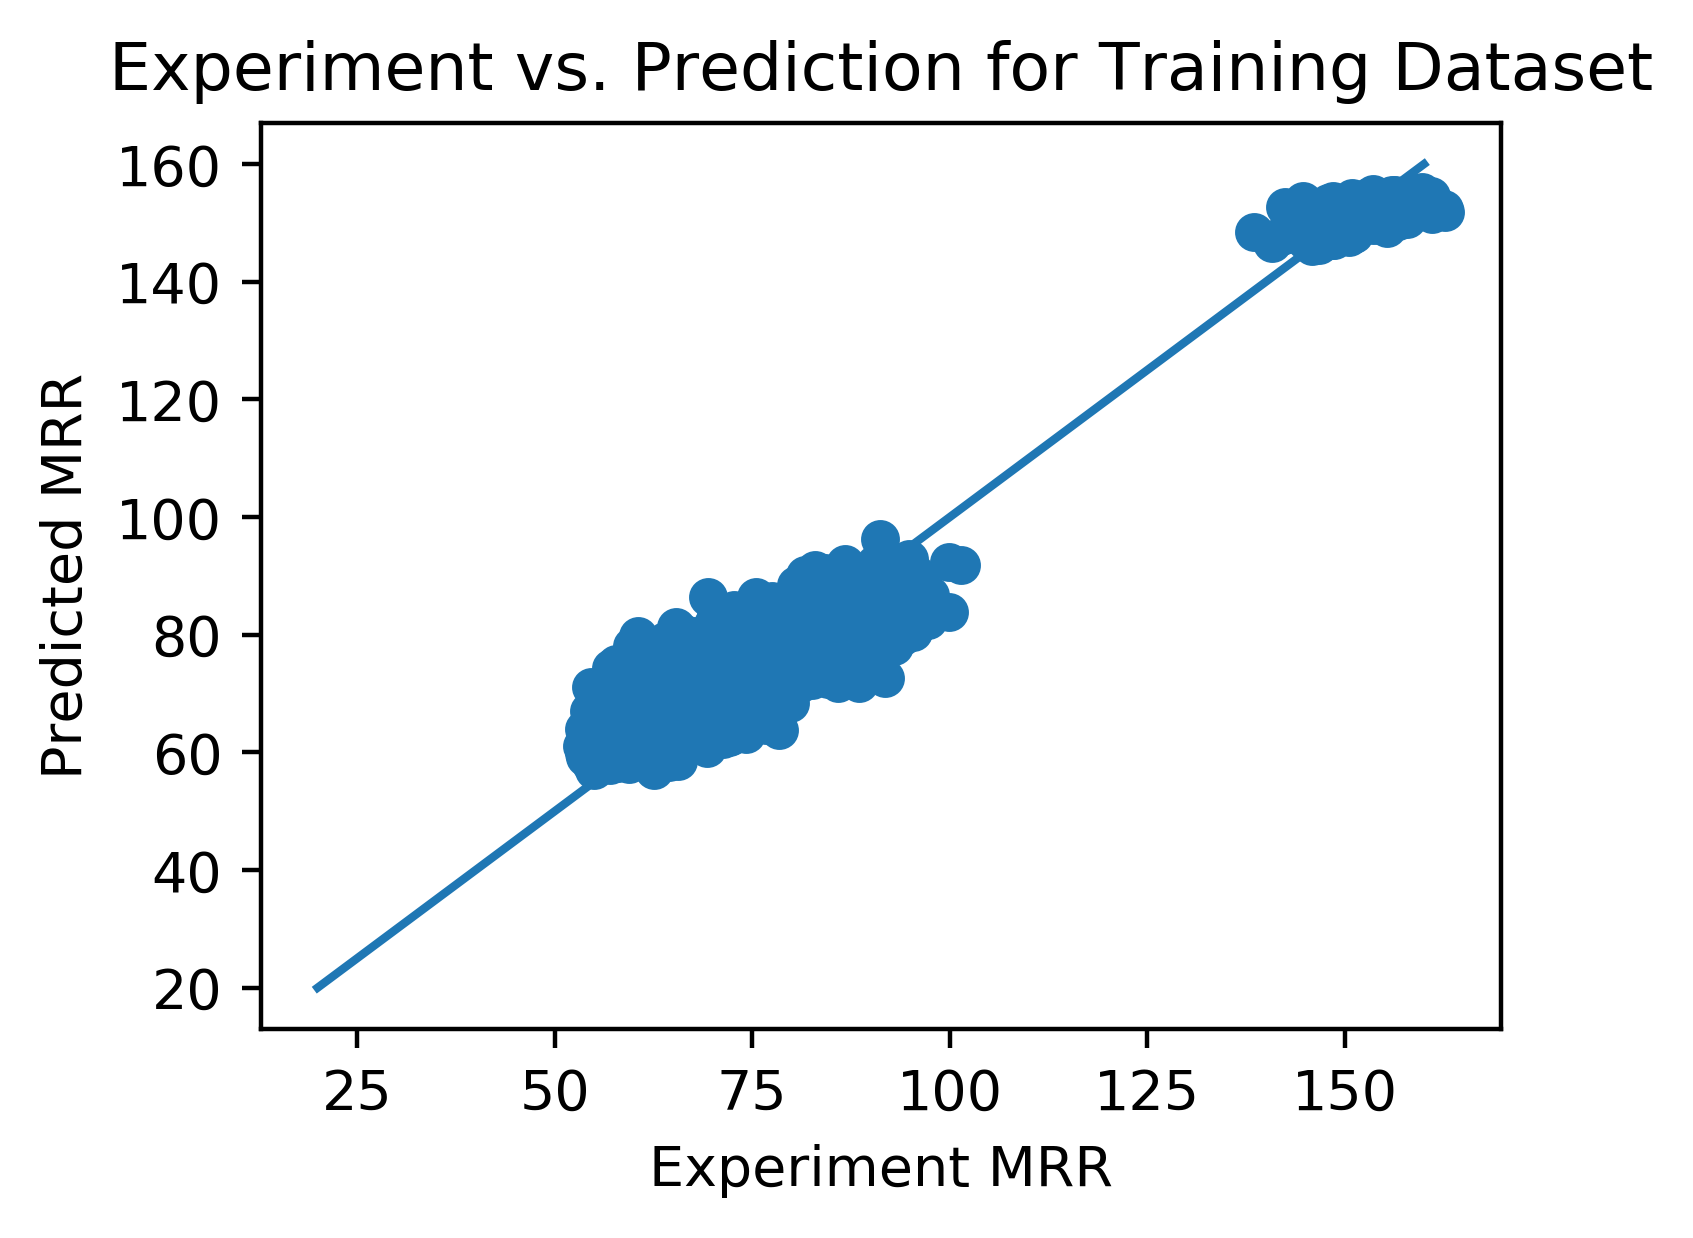

In [39]:
y_train_predict_class1 = regr_class1.predict(X_train[y_train_class])
y_train_predict_class2 = regr_class2.predict(X_train[np.logical_not(y_train_class)])
y_train_predict[y_train_predict_class] = y_train_predict_class1
y_train_predict[np.logical_not(y_train_predict_class)] = y_train_predict_class2


rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_predict))
print('train root mean square error is: {0}'.format(rmse_train))
plt.scatter(y_train, y_train_predict)
plt.plot([20, 160], [20, 160])
plt.xlabel("Experiment MRR")
plt.ylabel("Predicted MRR")
plt.title("Experiment vs. Prediction for Training Dataset")
plt.show()

test root mean square error is: 5.76161224136472


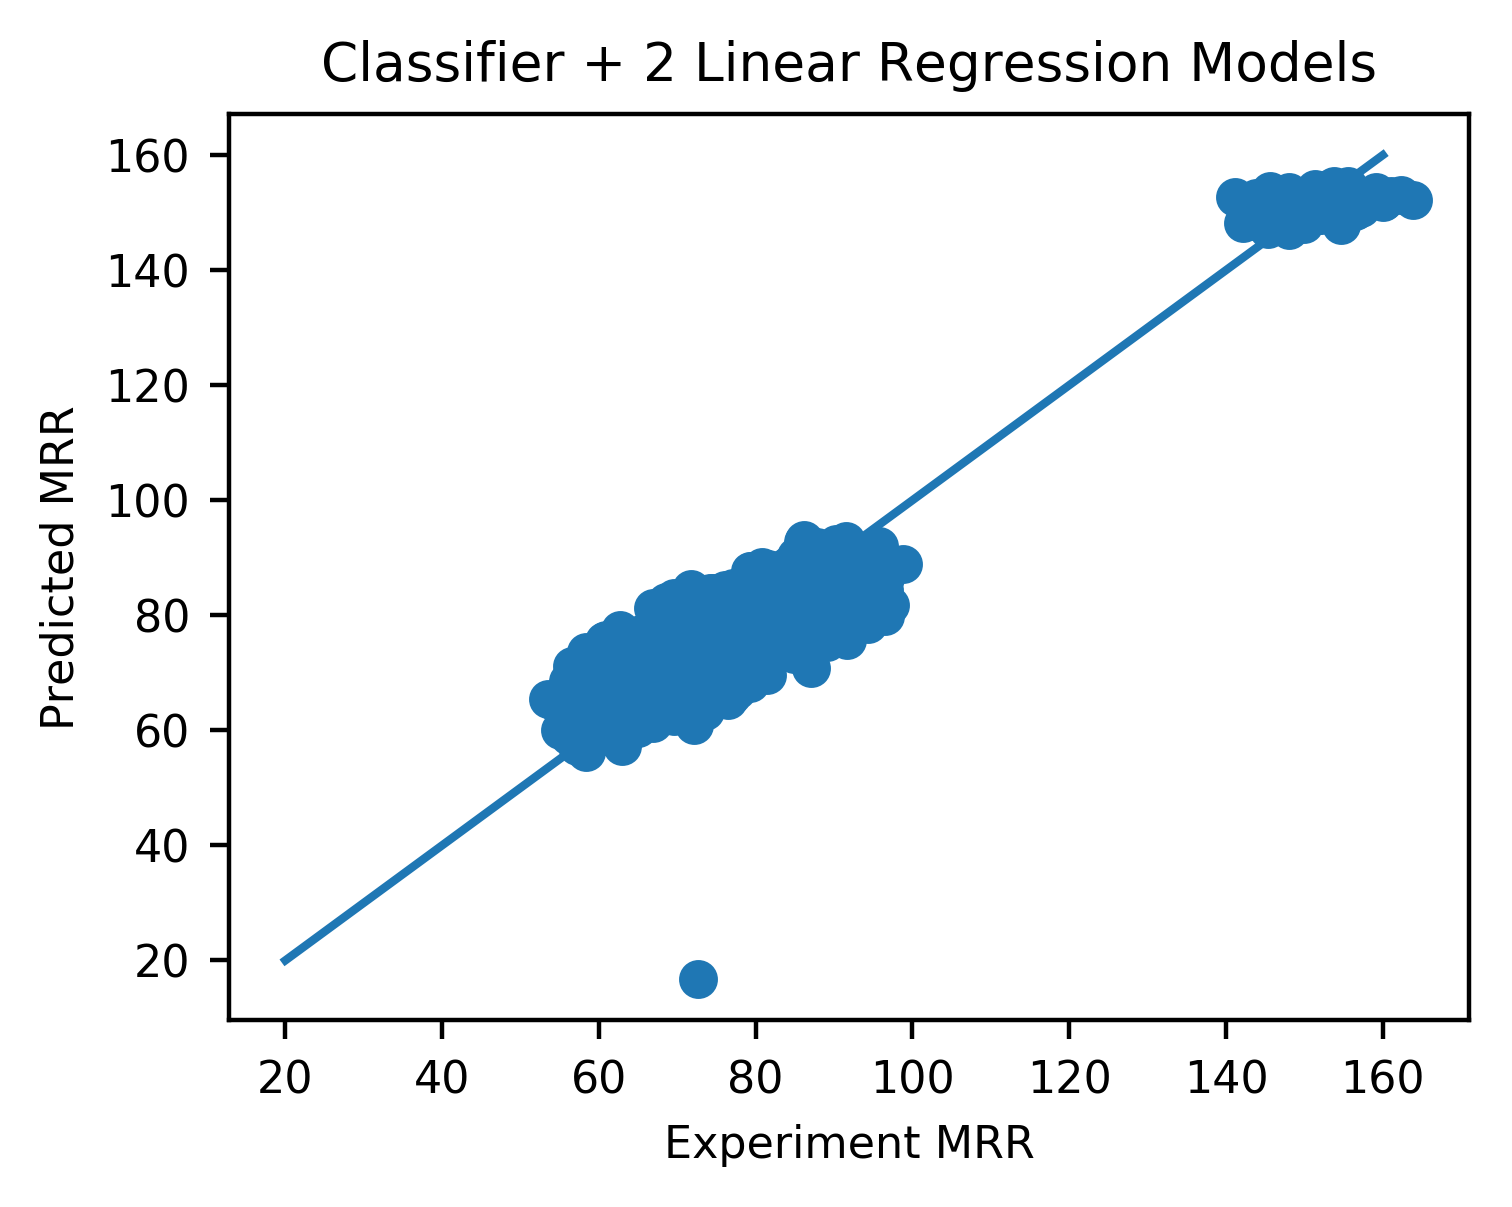

In [52]:
y_test_predict_class1 = regr_class1.predict(X_test[y_test_class])
y_test_predict_class2 = regr_class2.predict(X_test[np.logical_not(y_test_class)])
y_test_predict[y_test_predict_class] = y_test_predict_class1
y_test_predict[np.logical_not(y_test_predict_class)] = y_test_predict_class2


rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_predict))
print('test root mean square error is: {0}'.format(rmse_test))
plt.scatter(y_test, y_test_predict)
plt.plot([20, 160], [20, 160])
plt.xlabel("Experiment MRR")
plt.ylabel("Predicted MRR")
plt.title("Classifier + 2 Linear Regression Models")
plt.show()